# Initial Data Exploring

In this notebook, we'll be analyzing our raw data (as we downloaded it from [Kaggle](https://www.kaggle.com/datasets/pedrocsar/league-of-legends-worlds-20112022-stats/data)), so we can better understand the information we have. 

Then we'll proceed to the data cleaning process, getting rid of problematic values and columns, and then checking the data types in each column to avoid future problems.

Finally, we'll save all alterations to new CSV files that will be used for further data analysis in a separate notebook.

## Table of Contents

- [Initial Configuration](#initial-configuration)
    - [Functions](#functions)
- [Exploring the Datasets](#exploring-the-datasets)
    - ["champions_stats" Dataset](#champions_stats-dataset)
    - ["matchs_stats" Dataset](#matchs_stats-dataset)
    - ["players_stats" Dataset](#players_stats-dataset)
- [Data Cleaning](#data-cleaning)
    - [Initial Cleaning](#initial-cleaning)
    - ["champions_stats" Data Cleaning](#champions_stats-data-cleaning)
        - [Original "champions_stats"](#original-champions_stats)
        - ["champions_stats_s1_to_s3"](#champions_stats_s1_to_s3)
        - ["champions_stats_s4_to_s9"](#champions_stats_s4_to_s9)
        - ["champions_stats_s10_above"](#champions_stats_s10_above)
    - ["matchs_stats" Data Cleaning](#matchs_stats-data-cleaning)
    - ["players_stats" Data Cleaning](#players_stats-data-cleaning)
        - [Original "players_stats"](#original-players_stats)
        - ["players_stats_s1_to_s3"](#players_stats_s1_to_s3)
        - ["players_stats_s4_to_s9"](#players_stats_s4_to_s9)
        - ["players_stats_s10_above"](#players_stats_s10_above)
- [Saving Clean Datasets to CSV](#saving-clean-datasets-to-csv)
- [Closing](#closing)

---

### Initial Configuration

Base imports for this notebook to work. We're also configuring some of those modules, to ensure that the code runs smoothly and the visualization is clean.

In [332]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [333]:
# Ensuring the data loading script directory is in the system path
sys.path.insert(0, os.path.abspath('..'))

import data_loading

# Set up logging
data_loading.setup_logging()

# Loading data
champions_stats, matchs_stats, players_stats = data_loading.load_raw_data()

# Configuring pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Sets float values with two decimals
pd.options.mode.copy_on_write = True

# Configuring Seaborn and Matplotlib
plt.rcParams['figure.figsize'] = (30, 10)

2024-09-10 19:42:01,956 - INFO - champions_stats loaded succesfully.
2024-09-10 19:42:01,962 - INFO - matchs_stats loaded succesfully.
2024-09-10 19:42:01,965 - INFO - players_stats loaded succesfully.


#### Functions

**drop_obsolete_columns**

This function will remove a column (or a list of columns) from a specific dataset.

- **Parameters**:
    - `dataset` (pd.DataFrame): Which dataset will have the columns removed.
    - `columns` (list): List of column (or columns) that will be dropped from the dataset.
- **Returns**: 
    - `pd.DataFrame`: A DataFrame with the specified columns removed from the dataset.

In [334]:
def drop_obsolete_columns(dataset: pd.DataFrame, columns: list):
    """
    This function will remove a column (or a list of columns) from the specified dataset. 
    
    Parameters:
        dataset (pd.DataFrame): Which dataset will have the columns removed.
        columns (list): List of column (or columns) that will be dropped from the dataset.

    Returns:
        pd.DataFrame: A DataFrame with the specified columns removed from the dataset.    
    """
    
    dataset.drop(labels=columns, axis=1, inplace=True)
    return dataset

**find_nan_bans_by_season**

This function filters the dataset to find rows where *'banned_games'* is NaN, while matching the specified season.

- **Parameters:**
    - `dataset` (pd.DataFrame): The dataset that will be filtered.
    - `season` (int): From what season the data should be gathered.
- **Returns:** 
    - `pd.DataFrame`: A DataFrame with all rows where *'banned_games'* is NaN, during the specified season.

In [335]:
def find_nan_bans_by_season(dataset: pd.DataFrame, season: int) -> pd.DataFrame:
    """
    This function filters the dataset to find rows where 'banned_games' is NaN, while matching the specified season.

    Parameters:
        dataset (pd.DataFrame): The dataset that will be filtered.
        season (int): From what season the data should be gathered.

    Returns: 
        pd.DataFrame: A DataFrame with all rows where *'banned_games'* is NaN, during the specified season.
    """
    
    return dataset[(dataset['banned_games'].isna()) & (dataset['season'] == season)]

**fill_nan_with_zero**

This function turns every NaN value in the specified dataset to 0.

- **Parameters:**
    - `dataset` (pd.DataFrame): The dataset that will have the NaN values replaced.

- **Returns:**
    - `pd.Series`: A Series with the sum of every NaN value in each column of the dataset.

In [336]:
def fill_nan_with_zero(dataset: pd.DataFrame) -> pd.Series:
    """
    This function turns every NaN value in the specified dataset to 0.

    Parameters:
        dataset (pd.DataFrame): The dataset that will have the NaN values replaced.

    Returns:
        pd.Series: A Series with the sum of every NaN value in each column of the dataset.
    """
    
    nan_columns = dataset.columns[dataset.isna().any()].to_list()
    dataset[nan_columns] = dataset[nan_columns].fillna(value=0)
    return dataset.isna().sum()

---

### Exploring the Datasets

The first step for the project. We'll check how the raw data is presented from our initial Kaggle download, so we have a better understanding of what cleaning we have to do. This also helps us get some ideas for future analysis of said data.

##### "champions_stats" Dataset

In [337]:
champions_stats

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,12,Main,Nasus,1,1.30,NaN,1,1.00,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1341,12,Main,Rumble,1,1.30,NaN,1,1.00,0,1,0.00,2.00,6.00,1.00,0.50,234.00,7.74,10.50,347.00,11600.00,385.00,75.00,50.00,22.10
1342,12,Main,Wukong,1,1.30,NaN,1,1.00,0,1,0.00,2.00,5.00,5.00,1.40,159.00,3.75,11.40,270.00,11900.00,281.00,63.60,18.20,16.90
1343,12,Main,Xin Zhao,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50


This dataset grants us information on all champions that was played in all 12 iterations of Worlds Championship available to us, from season 1 to 12.

In [338]:
champions_stats.describe()

,season,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
count,1345.00,1345.00,1345.00,966.00,1345.00,1293.00,1345.00,1345.00,1293.00,1293.00,1293.00,1293.00,1293.00,1293.00,1293.00,1293.00,1293.00,480.00,480.00,1123.00,1123.00,1125.00
mean,7.97,14.86,24.98,9.62,7.96,4.63,3.98,3.98,45.69,2.57,2.77,5.68,3.76,208.90,6.24,11.61,345.71,12671.04,394.51,65.33,20.00,20.09
std,3.15,17.61,26.61,11.88,9.23,3.91,5.02,4.64,30.36,1.82,1.29,2.81,2.98,103.88,2.95,2.88,71.16,6110.56,175.33,14.05,12.36,3.62
min,1.00,1.00,1.20,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.50,0.23,4.10,173.00,1200.00,42.00,0.00,0.00,11.80
25%,6.00,2.00,4.10,2.00,1.00,1.00,1.00,1.00,27.30,1.00,2.00,4.00,2.00,145.00,4.39,9.70,295.00,8675.00,276.50,58.30,11.10,17.90
50%,9.00,7.00,13.80,5.00,4.00,3.00,2.00,2.00,50.00,2.38,2.63,5.32,3.10,230.00,7.17,11.60,354.00,12550.00,396.00,65.90,20.30,20.80
75%,11.00,21.00,38.30,12.00,11.00,7.00,6.00,6.00,62.50,3.55,3.33,7.08,4.42,283.96,8.58,13.40,397.00,16200.00,509.00,73.20,27.70,22.80
max,12.00,82.00,100.00,80.00,58.00,18.00,31.00,33.00,100.00,12.00,10.00,23.00,28.00,539.00,11.81,24.20,561.00,54700.00,1316.00,100.00,100.00,28.60


In [339]:
champions_stats.isnull().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                   379
played_games                     0
played_by_number_of_players     52
win                              0
lose                             0
win_rate                        52
kills                           52
deaths                          52
assists                         52
kill_death_assist_ratio         52
creep_score                     52
cs/min                          52
gold                            52
gold/min                        52
damage                         865
damage/min                     865
kill_participation             222
kill_share                     222
gold_share                     220
dtype: int64

A lot of null values scattered throughout this dataset. These will be addressed in the ["champions_stats" Data Cleaning](#champions_stats-data-cleaning) section of this notebook. 

In [340]:
champions_stats.nunique()

season                           12
event                             2
champion                        157
games_contests                   81
pick_ban_ratio                  345
banned_games                     59
played_games                     49
played_by_number_of_players      18
win                              29
lose                             28
win_rate                        141
kills                           317
deaths                          225
assists                         387
kill_death_assist_ratio         439
creep_score                    1022
cs/min                          675
gold                            146
gold/min                        292
damage                          201
damage/min                      335
kill_participation              351
kill_share                      340
gold_share                      152
dtype: int64

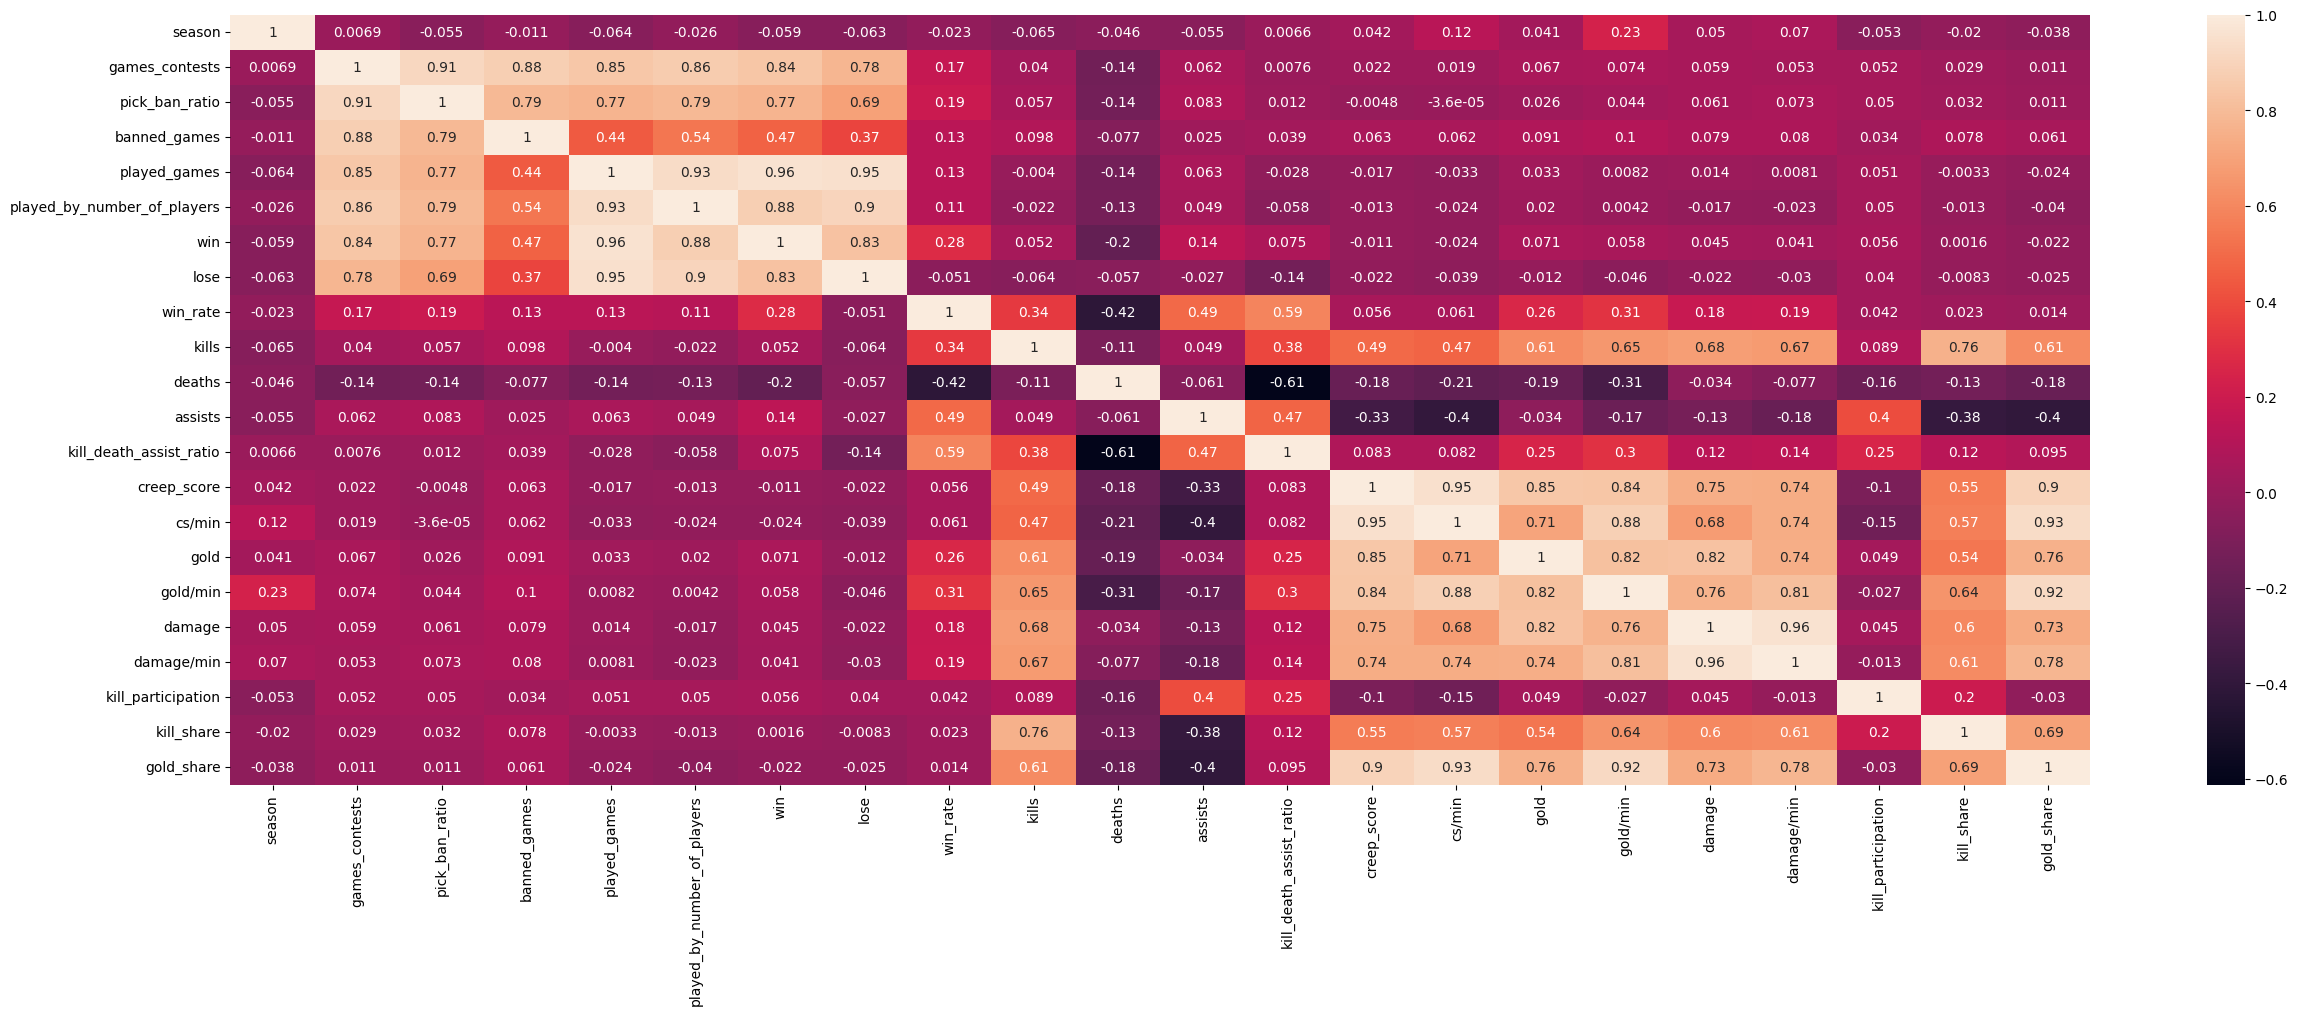

In [341]:
sns.heatmap(champions_stats.corr(numeric_only=True), annot=True)

plt.show()

The heatmap above already shows us some interesting things. For example, "gold/min" has only a 0.058 correlation with win, where I assumed it would be a little bit higher. However, the graph also demonstrates the (very obvious) correlation of "damage/min" with "gold/min". This one is easy to understand: the more gold you're generating, the more items you get, the more damage you get. This is also reflected in "cs/min" x "damage" (since, the better you farm, the better your gold generation is).

In [342]:
champions_stats.dtypes

season                           int64
event                           object
champion                        object
games_contests                   int64
pick_ban_ratio                 float64
banned_games                   float64
played_games                     int64
played_by_number_of_players    float64
win                              int64
lose                             int64
win_rate                       float64
kills                          float64
deaths                         float64
assists                        float64
kill_death_assist_ratio        float64
creep_score                    float64
cs/min                         float64
gold                           float64
gold/min                       float64
damage                         float64
damage/min                     float64
kill_participation             float64
kill_share                     float64
gold_share                     float64
dtype: object

#### "matchs_stats" Dataset

In [343]:
matchs_stats

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
0,1,2011-06-20,Main,NaN,Against_All_authority,Fnatic,Fnatic,Alistar,Gragas,Anivia,NaN,NaN,Rumble,Nunu,Amumu,NaN,NaN,Malzahar,Jarvan IV,Irelia,Corki,Janna,Brand,Warwick,Karthus,Ashe,Sona,MoMa,Linak,sOAZ,YellOwStaR,Kujaa,Shushei,Cyanide,xPeke,Lamia,Mellisan
1,1,2011-06-20,Main,NaN,Fnatic,Against_All_authority,Against_All_authority,Nunu,Warwick,Amumu,NaN,NaN,Gragas,Alistar,Rumble,NaN,NaN,Brand,Rammus,Malzahar,Corki,Janna,Irelia,Jarvan IV,Anivia,Ashe,Sona,Shushei,Cyanide,xPeke,Lamia,Mellisan,sOAZ,Linak,MoMa,YellOwStaR,Kujaa
2,1,2011-06-20,Main,NaN,Against_All_authority,TSM,Against_All_authority,Jarvan IV,Annie,Singed,NaN,NaN,Rumble,Corki,Vladimir,NaN,NaN,Sion,Nunu,Malzahar,Vayne,Janna,Cho'Gath,Warwick,Twisted Fate,Teemo,Alistar,YellOwStaR,Linak,MoMa,sOAZ,Kujaa,Chaox,TheOddOne,Reginald,TheRainMan,Xpecial
3,1,2011-06-20,Main,NaN,Epik_Gamer,TSM,TSM,Zilean,Vayne,Alistar,NaN,NaN,Akali,Vladimir,Corki,NaN,NaN,Singed,Amumu,Annie,Miss Fortune,Janna,Teemo,Nunu,Twisted Fate,Ashe,Taric,Dyrus,Dan Dinh,Salce,Westrice,Doublelift,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial
4,1,2011-06-20,Main,NaN,TSM,Epik_Gamer,TSM,Akali,Vladimir,Taric,NaN,NaN,Vayne,Zilean,Twisted Fate,NaN,NaN,Jarvan IV,Warwick,Annie,Corki,Alistar,Tristana,Nunu,Malzahar,Miss Fortune,Janna,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,Westrice,Dan Dinh,Salce,Dyrus,Doublelift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,12,2022-10-08,Main,12.18,T1,EDward_Gaming,T1,LeBlanc,Maokai,Graves,Renekton,Jarvan IV,Caitlyn,Sejuani,Aatrox,Kennen,Poppy,Fiora,Lee Sin,Akali,Sivir,Yuumi,Ornn,Vi,Azir,Kalista,Renata Glasc,Zeus,Oner,Faker,Gumayusi,Keria,Flandre,JieJie,Scout,Viper,Meiko
1066,12,2022-10-08,Main,12.18,JD_Gaming,Evil_Geniuses_2e-NA,JD_Gaming,Maokai,Akali,Ornn,Sylas,Mordekaiser,Caitlyn,Aatrox,Bel'Veth,Taliyah,Leona,Sejuani,Viego,Azir,Aphelios,Thresh,Gangplank,Graves,Viktor,Varus,Tahm Kench,369,Kanavi,Yagao,Hope,Missing,Impact,Inspired,jojopyun,Kaori,Vulcan
1067,12,2022-10-07,Main,12.18,CTBC_Flying_Oyster,100_Thieves,CTBC_Flying_Oyster,Yuumi,Sylas,Seraphine,Leona,Braum,Caitlyn,Maokai,Tristana,Nautilus,Alistar,Aatrox,Viego,Viktor,Kai'Sa,Rell,Fiora,Sejuani,Akali,Miss Fortune,Amumu,Rest,Gemini,Mission,Shunn,Koala,Ssumday,Closer,Abbedagge,FBI,huhi
1068,12,2022-10-07,Main,12.18,G2_Esports,DWG_KIA,DWG_KIA,Aatrox,Maokai,Varus,Fiora,Nautilus,Sylas,Sejuani,Senna,LeBlanc,Akali,Ornn,Jarvan IV,Seraphine,Caitlyn,Lux,Camille,Graves,Azir,Jhin,Leona,BrokenBlade,Jankos,caPs,Flakked,Targamas,Nuguri,Canyon,ShowMaker,deokdam,Kellin


This dataset is all about matches played through Worlds s1 to s12, including informations on bans, champions picked and the players on each team.
You will notice that, differently from our "champions_stats" dataset, we won't have a heatmap of correlations for this dataset. This is because the first one had more numeric data on it. Since this one is mainly text and names, we can't really make correlations (initially).

In [344]:
matchs_stats.isnull().sum()

season                 0
date                   0
event                  0
patch                122
blue_team              0
red_team               0
winner                 0
ban_1_blue_team        2
ban_2_blue_team        0
ban_3_blue_team        0
ban_4_blue_team      350
ban_5_blue_team      354
ban_1_red_team         2
ban_2_red_team         0
ban_3_red_team         0
ban_4_red_team       350
ban_5_red_team       351
pick_1_blue_team       0
pick_2_blue_team       0
pick_3_blue_team       0
pick_4_blue_team       0
pick_5_blue_team       0
pick_1_red_team        0
pick_2_red_team        0
pick_3_red_team        0
pick_4_red_team        0
pick_5_red_team        0
top_blue_team          0
jungler_blue_team      0
mid_blue_team          0
adc_blue_team          0
support_blue_team      0
top_red_team           0
jungler_red_team       0
mid_red_team           0
adc_red_team           0
support_red_team       0
dtype: int64

Quite a lot of missing bans! This is further explained, and dealt with accordingly, on the ["matchs_stats" Data Cleaning](#matchs_stats-data-cleaning) section.

In [345]:
matchs_stats.nunique()

season                12
date                 195
event                  2
patch                  9
blue_team            112
red_team             113
winner               103
ban_1_blue_team      122
ban_2_blue_team      126
ban_3_blue_team      125
ban_4_blue_team      125
ban_5_blue_team      122
ban_1_red_team       108
ban_2_red_team       113
ban_3_red_team       122
ban_4_red_team       115
ban_5_red_team       121
pick_1_blue_team      73
pick_2_blue_team      54
pick_3_blue_team      72
pick_4_blue_team      41
pick_5_blue_team      47
pick_1_red_team       79
pick_2_red_team       53
pick_3_red_team       80
pick_4_red_team       44
pick_5_red_team       48
top_blue_team        142
jungler_blue_team    138
mid_blue_team        134
adc_blue_team        138
support_blue_team    140
top_red_team         142
jungler_red_team     143
mid_red_team         137
adc_red_team         140
support_red_team     139
dtype: int64

An interesting assesment we can do here is that, although the bans vary throughout the seasons (given the larger amount of unique values on each of the bans), the champion picks themselves are mainly consistent. There are, indeed, strong pro play picks that remain staples throught League of Legends' history.

In [346]:
matchs_stats.dtypes

season                 int64
date                  object
event                 object
patch                float64
blue_team             object
red_team              object
winner                object
ban_1_blue_team       object
ban_2_blue_team       object
ban_3_blue_team       object
ban_4_blue_team       object
ban_5_blue_team       object
ban_1_red_team        object
ban_2_red_team        object
ban_3_red_team        object
ban_4_red_team        object
ban_5_red_team        object
pick_1_blue_team      object
pick_2_blue_team      object
pick_3_blue_team      object
pick_4_blue_team      object
pick_5_blue_team      object
pick_1_red_team       object
pick_2_red_team       object
pick_3_red_team       object
pick_4_red_team       object
pick_5_red_team       object
top_blue_team         object
jungler_blue_team     object
mid_blue_team         object
adc_blue_team         object
support_blue_team     object
top_red_team          object
jungler_red_team      object
mid_red_team  

#### "players_stats" Dataset

In [347]:
players_stats

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198,NaN,NaN,NaN,NaN,NaN
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259,NaN,NaN,NaN,NaN,NaN
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307,NaN,NaN,NaN,NaN,NaN
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293,NaN,NaN,NaN,NaN,NaN
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,12,Main,Top_Esports,JackeyLove,6,3,3,50.00,5.33,2.33,5.17,4.50,295.33,9.37,15.30,486,20700.00,656.00,76.80,39.00,26.10
1279,12,Main,Top_Esports,knight,6,3,3,50.00,4.33,1.17,5.50,8.43,283.50,8.99,13.90,442,22400.00,711.00,72.00,31.70,23.70
1280,12,Main,Top_Esports,Mark,6,3,3,50.00,1.17,2.00,9.33,5.25,24.00,0.76,7.70,245,5400.00,171.00,76.80,8.50,13.10
1281,12,Main,Top_Esports,Tian,6,3,3,50.00,1.83,2.33,7.33,3.93,174.00,5.52,10.50,332,10900.00,344.00,67.10,13.40,17.80


Finally, we come to a dataset that is focused on the players themselves, including their winrate on each iteration of the competition.

In [348]:
players_stats.describe()

,season,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
count,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,1283.00,409.00,409.00,1111.00,1111.00,1111.00
mean,7.60,8.34,4.17,4.17,43.98,2.42,2.68,5.57,3.63,203.79,6.05,11.46,339.51,12447.19,389.57,66.15,20.12,19.97
std,3.12,4.13,3.57,1.74,25.03,1.45,1.00,2.24,2.58,105.62,3.05,2.63,69.86,5008.75,155.07,9.47,10.71,3.60
min,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,4.67,0.17,4.80,173.00,2700.00,88.00,26.70,0.00,12.40
25%,5.00,6.00,1.00,3.00,28.60,1.33,2.00,4.11,2.08,128.70,3.79,9.60,288.50,9100.00,290.00,60.30,13.10,17.80
50%,8.00,7.00,3.00,4.00,44.40,2.25,2.60,5.25,3.05,231.38,7.08,11.60,347.00,12700.00,403.00,66.40,20.00,20.80
75%,10.00,10.00,6.00,5.00,60.00,3.38,3.22,6.81,4.33,284.75,8.54,13.40,393.00,16000.00,492.00,72.35,27.10,22.70
max,12.00,21.00,15.00,8.00,100.00,10.00,7.83,17.00,25.00,477.00,11.17,21.70,519.00,25200.00,822.00,100.00,100.00,26.90


In [349]:
players_stats.isnull().sum()

season                       0
event                        0
team                         0
player                       0
games_played                 0
wins                         0
loses                        0
win_rate                     0
kills                        0
deaths                       0
assists                      0
kill_death_assist_ratio      0
creep_score                  0
cs/min                       0
gold                         0
gold/min                     0
damage                     874
damage/min                 874
kill_participation         172
kill_share                 172
gold_share                 172
dtype: int64

A lot of missing information in the latter columns of this dataset. See the ["players_stats" Data Cleaning](#players_stats-data-cleaning) section to check the reason why, along with how we deal with them.

In [350]:
players_stats.nunique()

season                       12
event                         2
team                        114
player                      677
games_played                 21
wins                         16
loses                         9
win_rate                     55
kills                       299
deaths                      232
assists                     390
kill_death_assist_ratio     521
creep_score                1165
cs/min                      651
gold                        126
gold/min                    285
damage                      170
damage/min                  287
kill_participation          341
kill_share                  366
gold_share                  140
dtype: int64

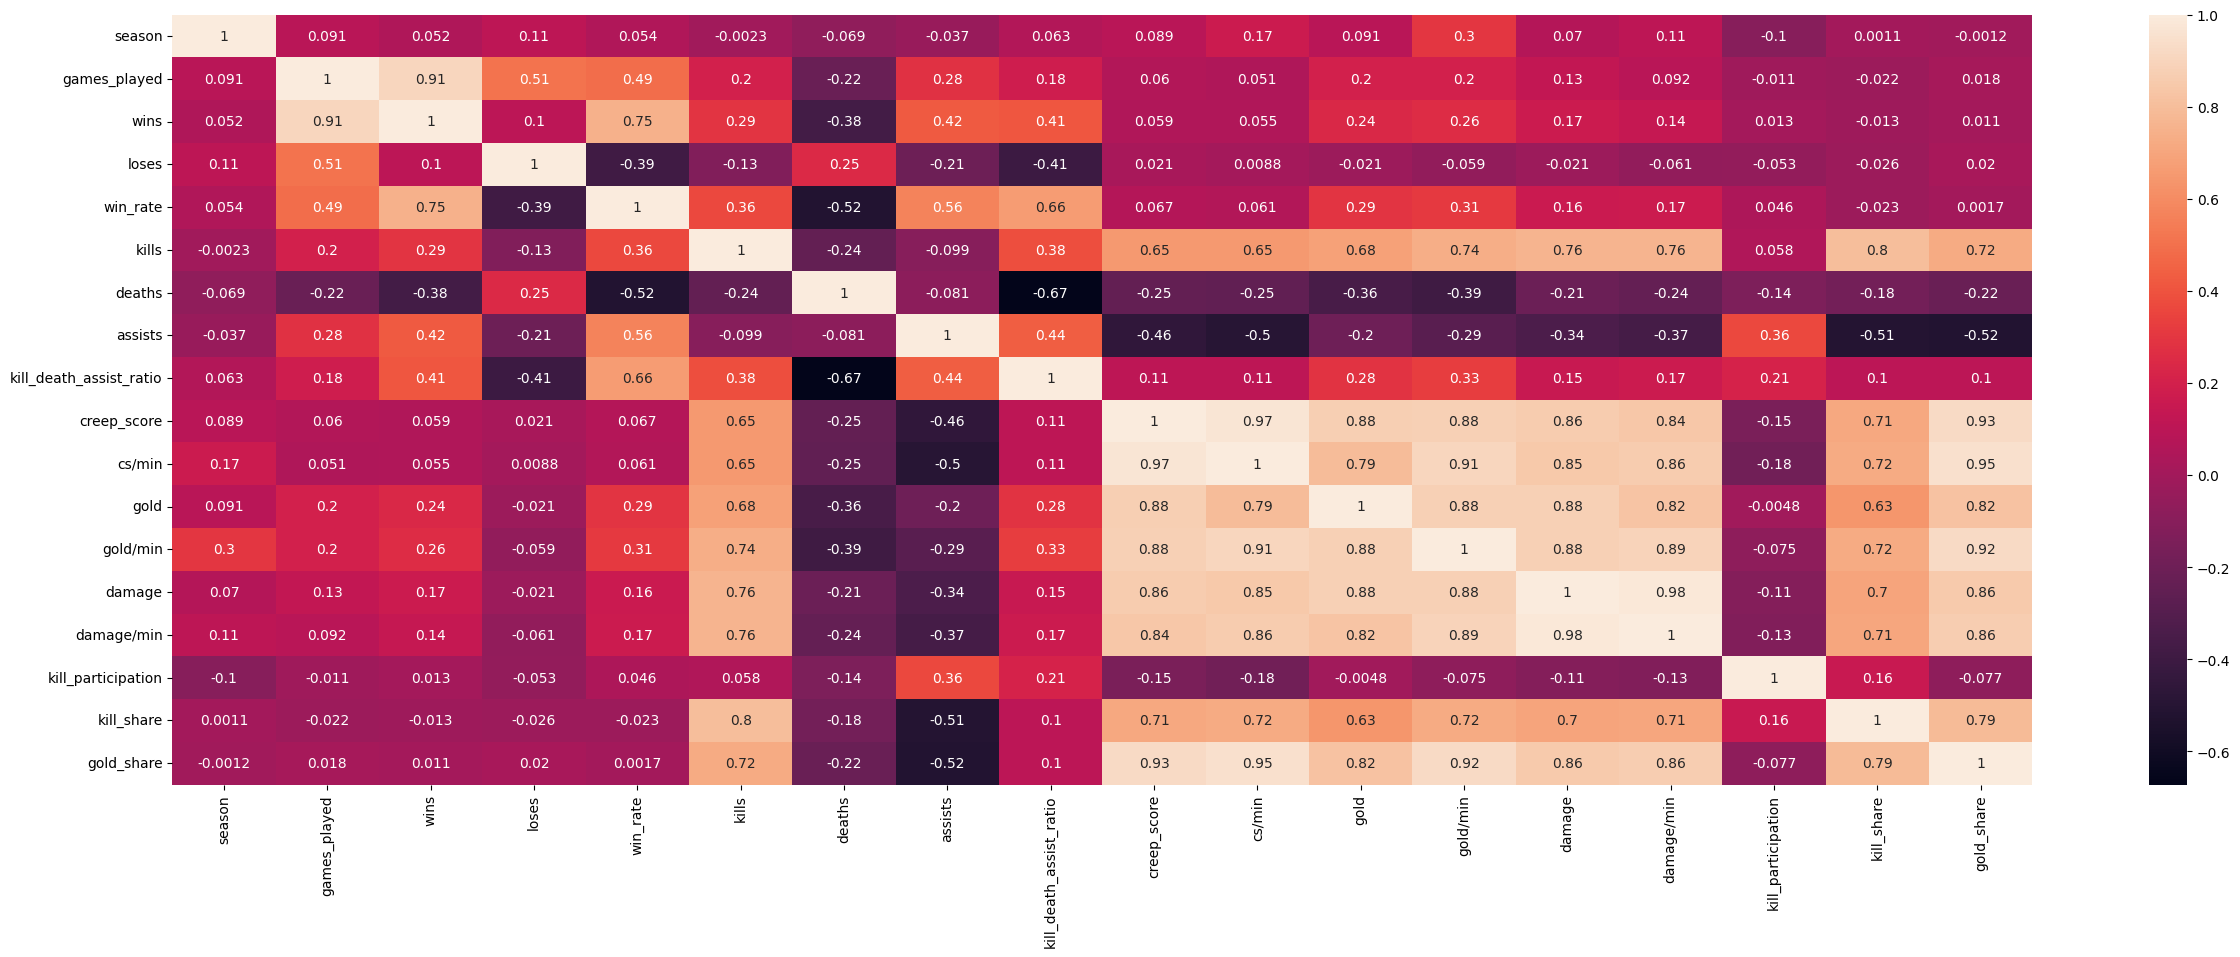

In [351]:
sns.heatmap(players_stats.corr(numeric_only=True), annot=True)

plt.show()

One interesting thing that popped out to me here was checking the "win_rate" correlations to kills, deaths, assists and the K/D ratio. First of all, there is some correlation to the K/D ratio, although not very high (0.66). However, I thought that, from the three, kills would have a higher relation. But that's not the case! Actually, assists seem to have more impact on the player's win rate.

In [352]:
players_stats.dtypes

season                       int64
event                       object
team                        object
player                      object
games_played                 int64
wins                         int64
loses                        int64
win_rate                   float64
kills                      float64
deaths                     float64
assists                    float64
kill_death_assist_ratio    float64
creep_score                float64
cs/min                     float64
gold                       float64
gold/min                     int64
damage                     float64
damage/min                 float64
kill_participation         float64
kill_share                 float64
gold_share                 float64
dtype: object

---

### Data Cleaning

Now that we have a better understanding of our datasets, and have seen its flaws, it's time for the Data Cleaning process.

#### Initial Cleaning

Before we start cleaning all datasets, it's important to realize something: by analyzing the "champions_stats" and "players_stats" datasets, it becomes evident that there's no available data for damage and damage/min before the season 10 of Worlds. Similarly, kill participation, kill share and gold share weren't collected before season 4! If that's a problem of the dataset themselves, or if Riot Games didn't have the necessary tools to do that analysis is not clear, but we have to deal with them separately as to not "contaminate" our own analysis when we get to that part.

As a "solution" to this problem, these datasets will all be divided in three different subsets:
- One subset ranging from season 1 ("s1") to season 3 ("s3"), with no **"damage"**, **"damage/min"**, **"kill_participation"**, **"kill_share"** and **"gold_share"** columns;
- One subset ranging from season 4 ("s4") to season 10 ("s9"), with no **"damage"** and **"damage/min"** columns;
- One subset ranging from season 10 ("s10") onwards, with all columns available in the original dataset.

The original datasets will keep their original names, and will have a more broad cleaning done (making it a bit less reliable, although still valuable). 

Additional information for this problem, or reliable sources, are welcome!

Before we do anything, though, we'll clean the original datasets dtypes (the datatypes for each column), if possible, so that the subsets already have that covered when they're created.

In [353]:
champions_stats.dtypes

season                           int64
event                           object
champion                        object
games_contests                   int64
pick_ban_ratio                 float64
banned_games                   float64
played_games                     int64
played_by_number_of_players    float64
win                              int64
lose                             int64
win_rate                       float64
kills                          float64
deaths                         float64
assists                        float64
kill_death_assist_ratio        float64
creep_score                    float64
cs/min                         float64
gold                           float64
gold/min                       float64
damage                         float64
damage/min                     float64
kill_participation             float64
kill_share                     float64
gold_share                     float64
dtype: object

The **"event"** column can definitely be a category of its own, since there are only two possible values (*"Main"* or *"Play in"*)

In [354]:
champions_stats['event'].unique()

array(['Main', 'Play in'], dtype=object)

There's also no logical reason why **"banned_games"** and **"played_by_number_of_players"** should be a float. However, we can't convert those columns just yet, since they have NaN values that need to be sorted out first.

With that in mind, let's fix what we can, and then split it into the subsets.

In [355]:
champions_stats = champions_stats.astype({
    'event': 'category',
})

champions_stats.dtypes

season                            int64
event                          category
champion                         object
games_contests                    int64
pick_ban_ratio                  float64
banned_games                    float64
played_games                      int64
played_by_number_of_players     float64
win                               int64
lose                              int64
win_rate                        float64
kills                           float64
deaths                          float64
assists                         float64
kill_death_assist_ratio         float64
creep_score                     float64
cs/min                          float64
gold                            float64
gold/min                        float64
damage                          float64
damage/min                      float64
kill_participation              float64
kill_share                      float64
gold_share                      float64
dtype: object

In [356]:
# Splitting the dataset

champions_stats_s1_to_s3 = champions_stats[champions_stats['season'] <= 3].copy() # We make a deep copy, so changes to the original dataset don't affect this one!
champions_stats_s4_to_s9 = champions_stats[(champions_stats['season'] >= 4) & (champions_stats['season'] <= 9)].copy()
champions_stats_s10_above = champions_stats[champions_stats['season'] >= 10].copy()

Let's do a quick check to see if all of them are separated accordingly. We'll call them, then check the first and last rows in the **"season"** column, to see if they respect their boundaries. Since it is an *int* column, we'll also sort it in ascending order, to make sure that we accomplished our initial task.

In [357]:
champions_stats_s1_to_s3.sort_values(by=['season'])

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,3,Main,Swain,1,1.60,NaN,1,1.00,0,1,0.00,2.00,5.00,4.00,1.20,263.00,7.55,10.70,307.00,NaN,NaN,NaN,NaN,NaN
170,3,Main,Teemo,1,1.60,NaN,1,1.00,0,1,0.00,3.00,6.00,8.00,1.83,164.00,4.77,9.30,270.00,NaN,NaN,NaN,NaN,NaN
171,3,Main,Xin Zhao,1,1.60,NaN,1,1.00,0,1,0.00,1.00,6.00,1.00,0.33,94.00,2.89,7.00,215.00,NaN,NaN,NaN,NaN,NaN
172,3,Main,Zilean,1,1.60,NaN,1,1.00,0,1,0.00,5.00,7.00,4.00,1.29,96.00,3.20,8.20,273.00,NaN,NaN,NaN,NaN,NaN


In [358]:
champions_stats_s4_to_s9.sort_values(by=['season'])

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
174,4,Main,Alistar,78,100.00,73.00,5,5.00,4,1,80.00,2.00,2.60,8.20,3.92,163.80,5.31,10.10,327.00,NaN,NaN,72.90,14.30,19.40
175,4,Main,Zilean,75,96.20,62.00,13,11.00,6,7,46.20,2.23,2.62,7.08,3.56,150.08,4.21,10.80,302.00,NaN,NaN,68.80,16.50,18.70
176,4,Main,Lee Sin,72,92.30,29.00,43,16.00,24,19,55.80,2.91,2.74,7.21,3.69,102.60,2.84,10.40,287.00,NaN,NaN,65.90,18.90,17.50
177,4,Main,Maokai,72,92.30,45.00,27,12.00,17,10,63.00,2.70,3.11,9.59,3.95,221.52,6.16,12.30,342.00,NaN,NaN,67.90,14.90,19.90
178,4,Main,Ryze,68,87.20,31.00,37,14.00,22,15,59.50,3.49,3.16,5.54,2.85,232.95,6.65,12.30,351.00,NaN,NaN,61.60,23.80,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,9,Play in,Renekton,29,67.40,16.00,13,6.00,5,8,38.50,1.92,2.31,2.92,2.10,248.85,7.43,12.10,362.00,NaN,NaN,42.30,16.80,20.60
672,9,Play in,Qiyana,38,88.40,30.00,8,7.00,5,3,62.50,4.88,2.75,5.25,3.68,189.50,5.36,12.50,352.00,NaN,NaN,57.40,27.70,19.10
671,9,Play in,Xayah,38,88.40,15.00,23,11.00,11,12,47.80,4.22,1.83,3.83,4.40,360.09,10.29,16.10,459.00,NaN,NaN,67.00,35.10,25.70
670,9,Play in,Syndra,41,95.30,27.00,14,10.00,9,5,64.30,3.93,2.21,3.71,3.45,330.64,8.81,15.20,405.00,NaN,NaN,53.50,27.50,22.20


In [359]:
champions_stats_s10_above.sort_values(by=['season'])

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
843,10,Play in,Nidalee,34,89.50,23.00,11,6.00,7,4,63.60,3.18,2.36,7.00,4.31,220.91,6.57,12.20,362.00,13900.00,415.00,72.70,22.70,20.40
844,10,Play in,Lillia,33,86.80,17.00,16,6.00,5,11,31.30,2.69,3.25,6.75,2.90,210.88,6.47,11.30,348.00,14900.00,459.00,76.60,21.80,20.40
845,10,Play in,Orianna,33,86.80,22.00,11,8.00,10,1,90.90,4.55,1.91,8.55,6.86,301.09,8.91,14.80,438.00,20800.00,614.00,81.40,28.20,23.60
846,10,Play in,Ornn,33,86.80,22.00,11,6.00,10,1,90.90,2.82,1.27,10.45,10.43,218.09,6.81,11.70,366.00,13700.00,429.00,74.10,15.70,19.70
847,10,Play in,Graves,29,76.30,12.00,17,8.00,12,5,70.60,4.06,1.29,6.29,8.00,212.65,6.90,11.70,380.00,10600.00,344.00,69.80,27.40,20.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,12,Play in,Sejuani,34,72.30,15.00,19,10.00,8,11,42.10,1.68,2.74,7.89,3.50,159.47,5.14,9.70,312.00,9800.00,315.00,70.00,12.30,17.70
1164,12,Play in,Maokai,35,74.50,13.00,22,11.00,15,7,68.20,2.09,2.77,8.64,3.87,145.86,4.52,10.10,313.00,12800.00,396.00,67.60,13.20,16.90
1163,12,Play in,Kalista,37,78.70,30.00,7,7.00,3,4,42.90,4.29,3.14,4.71,2.86,264.86,8.75,12.70,421.00,12300.00,407.00,58.30,27.80,23.60
1162,12,Play in,Sylas,39,83.00,21.00,18,9.00,12,6,66.70,4.78,2.56,6.11,4.26,258.89,8.18,13.20,416.00,16200.00,511.00,70.80,31.00,22.50


Great! Now, we'll follow the same steps for the other dataset.

In [360]:
players_stats.dtypes

season                       int64
event                       object
team                        object
player                      object
games_played                 int64
wins                         int64
loses                        int64
win_rate                   float64
kills                      float64
deaths                     float64
assists                    float64
kill_death_assist_ratio    float64
creep_score                float64
cs/min                     float64
gold                       float64
gold/min                     int64
damage                     float64
damage/min                 float64
kill_participation         float64
kill_share                 float64
gold_share                 float64
dtype: object

Besides changing **"event"** to a category, as we did previously, **"team"** could also be a category, since they are just different groups (a categorical data). Also, **"gold/min"** should be a float, since that value could be a decimal, even though it isn't the case in the dataset.

In [361]:
players_stats = players_stats.astype({
    'event': 'category',
    'team': 'category',
    'gold/min': 'float64'
})

players_stats.dtypes

season                        int64
event                      category
team                       category
player                       object
games_played                  int64
wins                          int64
loses                         int64
win_rate                    float64
kills                       float64
deaths                      float64
assists                     float64
kill_death_assist_ratio     float64
creep_score                 float64
cs/min                      float64
gold                        float64
gold/min                    float64
damage                      float64
damage/min                  float64
kill_participation          float64
kill_share                  float64
gold_share                  float64
dtype: object

In [362]:
players_stats.dtypes

season                        int64
event                      category
team                       category
player                       object
games_played                  int64
wins                          int64
loses                         int64
win_rate                    float64
kills                       float64
deaths                      float64
assists                     float64
kill_death_assist_ratio     float64
creep_score                 float64
cs/min                      float64
gold                        float64
gold/min                    float64
damage                      float64
damage/min                  float64
kill_participation          float64
kill_share                  float64
gold_share                  float64
dtype: object

In [363]:
# Splitting the dataset

players_stats_s1_to_s3 = players_stats[players_stats['season'] <= 3].copy()
players_stats_s4_to_s9 = players_stats[(players_stats['season'] >= 4) & (players_stats['season'] <= 9)].copy()
players_stats_s10_above = players_stats[players_stats['season'] >= 10].copy()

In [364]:
# Checking if they respect their season boundaries

players_stats_s1_to_s3.sort_values(by=['season'])

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,3,Main,TSM,Dyrus,8,2,6,25.00,2.50,5.38,5.50,1.49,211.50,5.90,10.60,296.00,NaN,NaN,NaN,NaN,NaN
168,3,Main,TSM,Reginald,8,2,6,25.00,3.38,5.00,5.13,1.70,218.38,6.09,10.80,302.00,NaN,NaN,NaN,NaN,NaN
169,3,Main,TSM,TheOddOne,8,2,6,25.00,2.63,3.63,7.63,2.83,132.00,3.68,9.30,260.00,NaN,NaN,NaN,NaN,NaN
170,3,Main,TSM,WildTurtle,8,2,6,25.00,5.38,4.00,5.75,2.78,295.88,8.26,13.40,375.00,NaN,NaN,NaN,NaN,NaN


In [365]:
players_stats_s4_to_s9.sort_values(by=['season'])

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
172,4,Main,Ahq_eSports_Club,GarnetDevil,7,3,4,42.90,2.57,4.14,6.14,2.10,256.57,7.21,12.20,342.00,NaN,NaN,57.00,16.80,22.30
173,4,Main,Ahq_eSports_Club,GreenTea,7,3,4,42.90,1.43,4.43,7.71,2.06,29.00,0.82,7.80,219.00,NaN,NaN,59.80,9.30,14.20
206,4,Main,KaBuM_21-_Esports,TinOwns,6,1,5,16.70,2.33,2.00,1.83,2.08,301.50,8.76,11.70,340.00,NaN,NaN,69.40,38.90,24.40
207,4,Main,LMQ,ackerman,6,2,4,33.30,2.17,5.17,5.50,1.48,176.67,4.76,10.30,278.00,NaN,NaN,67.60,19.10,18.90
208,4,Main,LMQ,Mor,6,2,4,33.30,0.50,4.33,9.17,2.23,29.33,0.79,8.30,223.00,NaN,NaN,85.30,4.40,15.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,9,Main,Team_Liquid,Xmithie,6,3,3,50.00,2.00,3.17,6.33,2.63,151.50,4.68,10.00,308.00,NaN,NaN,76.90,18.50,17.60
842,9,Main,Invictus_Gaming,Baolan,14,8,6,57.10,0.64,3.50,7.64,2.37,42.50,1.29,7.70,234.00,NaN,NaN,55.50,4.30,12.80
856,9,Main,Royal_Never_Give_Up,Uzi,6,3,3,50.00,5.00,1.50,5.67,7.11,385.83,11.13,17.30,499.00,NaN,NaN,82.10,38.50,26.70
858,9,Main,SK_Telecom_T1,Clid,14,9,5,64.30,2.57,2.29,7.79,4.53,169.07,5.14,11.20,342.00,NaN,NaN,66.80,16.60,17.80


In [366]:
players_stats_s10_above.sort_values(by=['season'])

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
874,10,Play in,INTZ,Envy,5,1,4,20.00,1.60,2.40,6.40,3.33,296.20,8.17,13.10,360.00,16200.00,446.00,75.50,15.10,21.90
875,10,Play in,INTZ,micaO,5,1,4,20.00,1.80,2.20,6.60,3.82,267.40,7.37,12.80,352.00,16500.00,454.00,79.20,17.00,21.50
876,10,Play in,INTZ,RedBert,5,1,4,20.00,1.00,3.20,6.60,2.38,47.60,1.31,8.00,222.00,5500.00,152.00,71.70,9.40,13.50
877,10,Play in,INTZ,Shini,5,1,4,20.00,1.60,3.20,5.00,2.06,206.00,5.68,11.20,308.00,9000.00,248.00,62.30,15.10,18.80
878,10,Play in,INTZ,Tay,5,1,4,20.00,4.60,3.20,2.60,2.25,296.60,8.18,14.40,398.00,15500.00,427.00,67.90,43.40,24.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,12,Main,Gen_2e-G,Doran,16,10,6,62.50,2.00,2.44,4.75,2.77,240.94,7.67,11.60,368.00,13800.00,439.00,54.00,16.00,20.40
1253,12,Main,Gen_2e-G,Chovy,16,10,6,62.50,3.94,1.38,3.63,5.50,304.06,9.68,13.70,438.00,17500.00,558.00,60.50,31.50,24.20
1252,12,Main,GAM_Esports,Sty1e,6,1,5,16.70,2.17,3.33,3.83,1.80,285.50,9.03,12.30,389.00,12800.00,404.00,66.70,24.10,23.80
1251,12,Main,GAM_Esports,Levi,6,1,5,16.70,2.67,4.50,5.67,1.85,185.83,5.88,10.90,344.00,16600.00,524.00,92.60,29.60,21.10


With that out of the way, we can move on to cleaning each dataset separately as we see fit.

#### "champions_stats" Data Cleaning

##### Original "champions_stats"

In [367]:
champions_stats

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,12,Main,Nasus,1,1.30,NaN,1,1.00,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1341,12,Main,Rumble,1,1.30,NaN,1,1.00,0,1,0.00,2.00,6.00,1.00,0.50,234.00,7.74,10.50,347.00,11600.00,385.00,75.00,50.00,22.10
1342,12,Main,Wukong,1,1.30,NaN,1,1.00,0,1,0.00,2.00,5.00,5.00,1.40,159.00,3.75,11.40,270.00,11900.00,281.00,63.60,18.20,16.90
1343,12,Main,Xin Zhao,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50


The original dataset, as stated before, will have a more superficial cleaning done. Let's check its NaN values.

In [368]:
champions_stats.isna().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                   379
played_games                     0
played_by_number_of_players     52
win                              0
lose                             0
win_rate                        52
kills                           52
deaths                          52
assists                         52
kill_death_assist_ratio         52
creep_score                     52
cs/min                          52
gold                            52
gold/min                        52
damage                         865
damage/min                     865
kill_participation             222
kill_share                     222
gold_share                     220
dtype: int64

Since all of those columns are numeric, we'll switch every NaN value to "0".

In [369]:
fill_nan_with_zero(champions_stats)

season                         0
event                          0
champion                       0
games_contests                 0
pick_ban_ratio                 0
banned_games                   0
played_games                   0
played_by_number_of_players    0
win                            0
lose                           0
win_rate                       0
kills                          0
deaths                         0
assists                        0
kill_death_assist_ratio        0
creep_score                    0
cs/min                         0
gold                           0
gold/min                       0
damage                         0
damage/min                     0
kill_participation             0
kill_share                     0
gold_share                     0
dtype: int64

In [370]:
# Clean 'champions_stats' data

champions_stats

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00,0.00,0.00,0.00,0.00,0.00
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00,0.00,0.00,0.00,0.00,0.00
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00,0.00,0.00,0.00,0.00,0.00
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00,0.00,0.00,0.00,0.00,0.00
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,12,Main,Nasus,1,1.30,0.00,1,1.00,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1341,12,Main,Rumble,1,1.30,0.00,1,1.00,0,1,0.00,2.00,6.00,1.00,0.50,234.00,7.74,10.50,347.00,11600.00,385.00,75.00,50.00,22.10
1342,12,Main,Wukong,1,1.30,0.00,1,1.00,0,1,0.00,2.00,5.00,5.00,1.40,159.00,3.75,11.40,270.00,11900.00,281.00,63.60,18.20,16.90
1343,12,Main,Xin Zhao,1,1.30,0.00,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50


##### "champions_stats_s1_to_s3"

In [371]:
champions_stats_s1_to_s3

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,3,Main,Swain,1,1.60,NaN,1,1.00,0,1,0.00,2.00,5.00,4.00,1.20,263.00,7.55,10.70,307.00,NaN,NaN,NaN,NaN,NaN
170,3,Main,Teemo,1,1.60,NaN,1,1.00,0,1,0.00,3.00,6.00,8.00,1.83,164.00,4.77,9.30,270.00,NaN,NaN,NaN,NaN,NaN
171,3,Main,Xin Zhao,1,1.60,NaN,1,1.00,0,1,0.00,1.00,6.00,1.00,0.33,94.00,2.89,7.00,215.00,NaN,NaN,NaN,NaN,NaN
172,3,Main,Zilean,1,1.60,NaN,1,1.00,0,1,0.00,5.00,7.00,4.00,1.29,96.00,3.20,8.20,273.00,NaN,NaN,NaN,NaN,NaN


In [372]:
champions_stats_s1_to_s3.isna().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                    76
played_games                     0
played_by_number_of_players      6
win                              0
lose                             0
win_rate                         6
kills                            6
deaths                           6
assists                          6
kill_death_assist_ratio          6
creep_score                      6
cs/min                           6
gold                             6
gold/min                         6
damage                         174
damage/min                     174
kill_participation             174
kill_share                     174
gold_share                     174
dtype: int64

First of all, since the last columns don't have any available data, we'll just drop those.

In [373]:
obsolete_columns_s1_to_s3 = ['damage', 'damage/min', 'kill_participation', 'kill_share', 'gold_share']

drop_obsolete_columns(champions_stats_s1_to_s3, obsolete_columns_s1_to_s3)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
0,1,Main,Nunu,27,96.40,9.00,18,6.00,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00
1,1,Main,Alistar,25,89.30,12.00,13,4.00,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00
2,1,Main,Rumble,23,82.10,21.00,2,2.00,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00
3,1,Main,Vladimir,22,78.60,14.00,8,5.00,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00
4,1,Main,Twisted Fate,22,78.60,18.00,4,2.00,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,3,Main,Swain,1,1.60,NaN,1,1.00,0,1,0.00,2.00,5.00,4.00,1.20,263.00,7.55,10.70,307.00
170,3,Main,Teemo,1,1.60,NaN,1,1.00,0,1,0.00,3.00,6.00,8.00,1.83,164.00,4.77,9.30,270.00
171,3,Main,Xin Zhao,1,1.60,NaN,1,1.00,0,1,0.00,1.00,6.00,1.00,0.33,94.00,2.89,7.00,215.00
172,3,Main,Zilean,1,1.60,NaN,1,1.00,0,1,0.00,5.00,7.00,4.00,1.29,96.00,3.20,8.20,273.00


In [374]:
champions_stats_s1_to_s3.isna().sum()

season                          0
event                           0
champion                        0
games_contests                  0
pick_ban_ratio                  0
banned_games                   76
played_games                    0
played_by_number_of_players     6
win                             0
lose                            0
win_rate                        6
kills                           6
deaths                          6
assists                         6
kill_death_assist_ratio         6
creep_score                     6
cs/min                          6
gold                            6
gold/min                        6
dtype: int64

Cool. With that out of the way, let's take a closer look at what's happening with all those NaN values on **"banned_games"**, season by season, starting with season 1.

We'll use Pandas "sample" function to give us 10 random rows on our result, to avoid biases. You can also rerun the cells to check for different values (unless you already ran through the cleaning process, in which case it will throw you an error).

In [375]:
find_nan_bans_by_season(champions_stats_s1_to_s3, 1).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
28,1,Main,Swain,5,17.90,NaN,5,4.00,2,3,40.00,2.40,3.00,4.80,2.40,186.20,5.29,9.30,266.00
37,1,Main,Sion,1,3.60,NaN,1,1.00,1,0,100.00,2.00,0.00,6.00,8.00,253.00,7.54,11.90,355.00
13,1,Main,Malzahar,16,57.10,NaN,16,6.00,9,7,56.30,4.19,2.63,5.81,3.81,224.44,6.12,11.40,310.00
29,1,Main,Caitlyn,4,14.30,NaN,4,3.00,0,4,0.00,0.50,3.75,1.25,0.47,220.75,6.96,8.30,261.00
31,1,Main,Tristana,3,10.70,NaN,3,2.00,1,2,33.30,5.67,4.33,0.67,1.46,221.67,6.52,10.90,320.00
43,1,Main,Poppy,1,3.60,NaN,1,1.00,0,1,0.00,0.00,2.00,4.00,2.00,82.00,2.84,5.80,201.00
35,1,Main,Teemo,2,7.10,NaN,2,1.00,1,1,50.00,9.00,3.00,6.50,5.17,273.50,5.90,16.90,363.00
20,1,Main,Miss Fortune,8,28.60,NaN,8,4.00,2,6,25.00,2.63,2.88,2.75,1.87,249.38,6.64,11.30,302.00
40,1,Main,Garen,1,3.60,NaN,1,1.00,0,1,0.00,5.00,5.00,3.00,1.60,110.00,3.71,7.60,256.00
44,1,Main,Rammus,1,3.60,NaN,1,1.00,0,1,0.00,1.00,4.00,5.00,1.50,100.00,2.44,8.80,215.00


Clearly, all of these champions were not banned throughout the competition, since the **"games_contests"** value is equal to **"played_games"**. Stands to reason that the value should be *"0"*, not an NaN. The same is true for the other seasons, as seen below.

In [376]:
# Season 2

find_nan_bans_by_season(champions_stats_s1_to_s3, 2).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
91,2,Main,Xin Zhao,2,6.50,NaN,2,2.00,2,0,100.00,2.00,2.50,15.50,7.00,136.00,4.24,9.60,299.00
99,2,Main,Jarvan IV,1,3.20,NaN,1,1.00,0,1,0.00,6.00,3.00,14.00,6.67,297.00,7.16,14.00,337.00
101,2,Main,Swain,1,3.20,NaN,1,1.00,0,1,0.00,8.00,5.00,10.00,3.60,243.00,5.86,13.20,318.00
82,2,Main,Cassiopeia,4,12.90,NaN,4,2.00,1,3,25.00,4.75,2.75,2.75,2.73,204.75,6.90,9.40,317.00
102,2,Main,Tristana,1,3.20,NaN,1,1.00,0,1,0.00,0.00,5.00,0.00,0.00,200.00,7.01,7.00,245.00
100,2,Main,Riven,1,3.20,NaN,1,1.00,0,1,0.00,2.00,6.00,1.00,0.50,242.00,5.97,10.20,251.00
94,2,Main,Nocturne,2,6.50,NaN,2,2.00,0,2,0.00,2.50,5.50,9.00,2.09,224.50,4.65,12.90,267.00
90,2,Main,Singed,2,6.50,NaN,2,1.00,2,0,100.00,3.50,1.00,6.50,10.00,287.00,8.17,13.20,376.00
92,2,Main,Zilean,2,6.50,NaN,2,1.00,1,1,50.00,3.50,3.50,8.00,3.29,212.00,7.30,9.30,319.00
78,2,Main,Udyr,5,16.10,NaN,5,4.00,0,5,0.00,0.60,3.80,2.20,0.74,128.40,4.06,7.40,233.00


In [377]:
# Season 3

find_nan_bans_by_season(champions_stats_s1_to_s3, 3).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
155,3,Main,Shyvana,2,3.20,NaN,2,2.00,0,2,0.00,0.50,4.50,1.50,0.44,225.50,6.87,9.20,280.00
157,3,Main,Cassiopeia,1,1.60,NaN,1,1.00,1,0,100.00,6.00,0.00,3.00,9.00,319.00,8.65,15.70,426.00
166,3,Main,Karma,1,1.60,NaN,1,1.00,0,1,0.00,3.00,7.00,3.00,0.86,85.00,3.55,6.20,259.00
170,3,Main,Teemo,1,1.60,NaN,1,1.00,0,1,0.00,3.00,6.00,8.00,1.83,164.00,4.77,9.30,270.00
164,3,Main,Dr. Mundo,1,1.60,NaN,1,1.00,0,1,0.00,1.00,7.00,1.00,0.29,99.00,4.14,5.30,221.00
146,3,Main,Nidalee,3,4.80,NaN,3,3.00,2,1,66.70,2.33,1.67,2.67,3.00,250.67,7.41,11.70,345.00
165,3,Main,Hecarim,1,1.60,NaN,1,1.00,0,1,0.00,8.00,2.00,7.00,7.50,173.00,5.03,11.30,328.00
168,3,Main,Soraka,1,1.60,NaN,1,1.00,0,1,0.00,0.00,8.00,8.00,1.00,120.00,4.00,6.40,213.00
154,3,Main,Syndra,2,3.20,NaN,2,1.00,1,1,50.00,9.00,3.50,7.50,4.71,271.00,9.12,13.00,438.00
147,3,Main,Diana,3,4.80,NaN,3,3.00,1,2,33.30,3.33,3.33,4.67,2.40,249.00,7.85,10.90,345.00


With that assessment, we proceed to make the necessary changes.

In [378]:
champions_stats_s1_to_s3['banned_games'] = champions_stats_s1_to_s3['banned_games'].fillna(0)

champions_stats_s1_to_s3.isna().sum()

season                         0
event                          0
champion                       0
games_contests                 0
pick_ban_ratio                 0
banned_games                   0
played_games                   0
played_by_number_of_players    6
win                            0
lose                           0
win_rate                       6
kills                          6
deaths                         6
assists                        6
kill_death_assist_ratio        6
creep_score                    6
cs/min                         6
gold                           6
gold/min                       6
dtype: int64

For the remaining NaNs, I have a feeling that all of them are champions that were never played in the competition, only banned. Let's find out.

In [379]:
# Quick check on the "kills" column NaNs (since it's shorter to type it).

champions_stats_s1_to_s3[champions_stats_s1_to_s3['kills'].isna()]

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
71,2,Main,Twisted Fate,7,22.60,7.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,2,Main,Sivir,3,9.70,3.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2,Main,Draven,2,6.50,2.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,2,Main,Gangplank,1,3.20,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2,Main,Twitch,1,3.20,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,3,Main,Ziggs,1,1.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Just as I suspected (**"played_games"** is 0). Also, these 6 rows are responsible for the NaN values in the other columns as well. It makes it easy for us to clean it up with a quick change to *"0"*.

In [380]:
fill_nan_with_zero(champions_stats_s1_to_s3)

season                         0
event                          0
champion                       0
games_contests                 0
pick_ban_ratio                 0
banned_games                   0
played_games                   0
played_by_number_of_players    0
win                            0
lose                           0
win_rate                       0
kills                          0
deaths                         0
assists                        0
kill_death_assist_ratio        0
creep_score                    0
cs/min                         0
gold                           0
gold/min                       0
dtype: int64

With all NaN values out of the way, there's still one less thing to do. Remember in our [Initial Cleaning](#initial-cleaning) section, when we couldn't change the "banned_games" and "played_by_number_of_players" columns because there were NaN values? Well, that's not an issue anymore!

In [381]:
champions_stats_s1_to_s3 = champions_stats_s1_to_s3.astype({
    'champion': 'category',
    'banned_games': 'int64',
    'played_by_number_of_players': 'int64'
})

champions_stats_s1_to_s3.dtypes

season                            int64
event                          category
champion                       category
games_contests                    int64
pick_ban_ratio                  float64
banned_games                      int64
played_games                      int64
played_by_number_of_players       int64
win                               int64
lose                              int64
win_rate                        float64
kills                           float64
deaths                          float64
assists                         float64
kill_death_assist_ratio         float64
creep_score                     float64
cs/min                          float64
gold                            float64
gold/min                        float64
dtype: object

In [382]:
# Clean "champions_stats_s1_to_s3" dataset

champions_stats_s1_to_s3

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
0,1,Main,Nunu,27,96.40,9,18,6,12,6,66.70,1.06,2.67,8.61,3.63,90.17,2.46,9.40,256.00
1,1,Main,Alistar,25,89.30,12,13,4,8,5,61.50,3.46,2.69,7.38,4.03,114.00,3.11,9.60,261.00
2,1,Main,Rumble,23,82.10,21,2,2,2,0,100.00,3.50,1.50,9.00,8.33,162.00,5.02,10.10,311.00
3,1,Main,Vladimir,22,78.60,14,8,5,3,5,37.50,4.50,3.50,3.88,2.39,224.63,5.99,11.20,298.00
4,1,Main,Twisted Fate,22,78.60,18,4,2,2,2,50.00,2.00,4.50,5.50,1.67,206.50,5.43,11.40,299.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,3,Main,Swain,1,1.60,0,1,1,0,1,0.00,2.00,5.00,4.00,1.20,263.00,7.55,10.70,307.00
170,3,Main,Teemo,1,1.60,0,1,1,0,1,0.00,3.00,6.00,8.00,1.83,164.00,4.77,9.30,270.00
171,3,Main,Xin Zhao,1,1.60,0,1,1,0,1,0.00,1.00,6.00,1.00,0.33,94.00,2.89,7.00,215.00
172,3,Main,Zilean,1,1.60,0,1,1,0,1,0.00,5.00,7.00,4.00,1.29,96.00,3.20,8.20,273.00


##### "champions_stats_s4_to_s9"

In [383]:
champions_stats_s4_to_s9

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
174,4,Main,Alistar,78,100.00,73.00,5,5.00,4,1,80.00,2.00,2.60,8.20,3.92,163.80,5.31,10.10,327.00,NaN,NaN,72.90,14.30,19.40
175,4,Main,Zilean,75,96.20,62.00,13,11.00,6,7,46.20,2.23,2.62,7.08,3.56,150.08,4.21,10.80,302.00,NaN,NaN,68.80,16.50,18.70
176,4,Main,Lee Sin,72,92.30,29.00,43,16.00,24,19,55.80,2.91,2.74,7.21,3.69,102.60,2.84,10.40,287.00,NaN,NaN,65.90,18.90,17.50
177,4,Main,Maokai,72,92.30,45.00,27,12.00,17,10,63.00,2.70,3.11,9.59,3.95,221.52,6.16,12.30,342.00,NaN,NaN,67.90,14.90,19.90
178,4,Main,Ryze,68,87.20,31.00,37,14.00,22,15,59.50,3.49,3.16,5.54,2.85,232.95,6.65,12.30,351.00,NaN,NaN,61.60,23.80,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,9,Main,Neeko,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,4.00,1.67,292.00,8.45,12.20,353.00,NaN,NaN,62.50,12.50,19.90
839,9,Main,Rengar,1,1.30,NaN,1,1.00,0,1,0.00,5.00,4.00,0.00,1.25,208.00,7.96,10.60,404.00,NaN,NaN,50.00,50.00,23.10
840,9,Main,Sejuani,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,1.00,1.00,124.00,4.74,7.20,275.00,NaN,NaN,100.00,50.00,19.60
841,9,Main,Viktor,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,2.00,1.50,245.00,7.52,10.20,314.00,NaN,NaN,60.00,20.00,19.50


In [384]:
champions_stats_s4_to_s9.isna().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                   196
played_games                     0
played_by_number_of_players     24
win                              0
lose                             0
win_rate                        24
kills                           24
deaths                          24
assists                         24
kill_death_assist_ratio         24
creep_score                     24
cs/min                          24
gold                            24
gold/min                        24
damage                         669
damage/min                     669
kill_participation              26
kill_share                      26
gold_share                      24
dtype: int64

First of all, let's get rid of the obsolete columns. In this case, it's **"damage"** and **"damage/min"**.

In [385]:
obsolete_columns_s4_to_s9 = ['damage', 'damage/min']

drop_obsolete_columns(champions_stats_s4_to_s9, obsolete_columns_s4_to_s9)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
174,4,Main,Alistar,78,100.00,73.00,5,5.00,4,1,80.00,2.00,2.60,8.20,3.92,163.80,5.31,10.10,327.00,72.90,14.30,19.40
175,4,Main,Zilean,75,96.20,62.00,13,11.00,6,7,46.20,2.23,2.62,7.08,3.56,150.08,4.21,10.80,302.00,68.80,16.50,18.70
176,4,Main,Lee Sin,72,92.30,29.00,43,16.00,24,19,55.80,2.91,2.74,7.21,3.69,102.60,2.84,10.40,287.00,65.90,18.90,17.50
177,4,Main,Maokai,72,92.30,45.00,27,12.00,17,10,63.00,2.70,3.11,9.59,3.95,221.52,6.16,12.30,342.00,67.90,14.90,19.90
178,4,Main,Ryze,68,87.20,31.00,37,14.00,22,15,59.50,3.49,3.16,5.54,2.85,232.95,6.65,12.30,351.00,61.60,23.80,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,9,Main,Neeko,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,4.00,1.67,292.00,8.45,12.20,353.00,62.50,12.50,19.90
839,9,Main,Rengar,1,1.30,NaN,1,1.00,0,1,0.00,5.00,4.00,0.00,1.25,208.00,7.96,10.60,404.00,50.00,50.00,23.10
840,9,Main,Sejuani,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,1.00,1.00,124.00,4.74,7.20,275.00,100.00,50.00,19.60
841,9,Main,Viktor,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,2.00,1.50,245.00,7.52,10.20,314.00,60.00,20.00,19.50


In [386]:
champions_stats_s4_to_s9.isna().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                   196
played_games                     0
played_by_number_of_players     24
win                              0
lose                             0
win_rate                        24
kills                           24
deaths                          24
assists                         24
kill_death_assist_ratio         24
creep_score                     24
cs/min                          24
gold                            24
gold/min                        24
kill_participation              26
kill_share                      26
gold_share                      24
dtype: int64

In theory, **"banned_games"** NaN values should be *"0"*, as was the case with the previous dataset. To confirm this, let's take a quick glance at the different data available for us, by seasons.

In [387]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 4).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
215,4,Main,Blitzcrank,3,3.80,NaN,3,1.00,0,3,0.00,1.33,6.33,7.00,1.32,23.33,0.80,6.30,216.00,71.40,11.40,15.70
223,4,Main,Ezreal,2,2.60,NaN,2,2.00,0,2,0.00,3.00,1.00,2.00,5.00,226.50,6.37,10.80,305.00,47.60,28.60,22.10
221,4,Main,Singed,2,2.60,NaN,2,1.00,1,1,50.00,3.50,2.50,13.00,6.60,277.50,8.23,13.30,395.00,70.20,14.90,22.00
216,4,Main,Sona,3,3.80,NaN,3,2.00,0,3,0.00,0.33,4.00,4.33,1.17,12.00,0.40,6.20,207.00,73.70,5.30,14.30
194,4,Main,Corki,22,28.20,NaN,22,7.00,12,10,54.50,4.14,2.36,5.32,4.00,275.45,7.82,13.30,379.00,63.00,27.60,22.80
212,4,Main,Vayne,4,5.10,NaN,4,3.00,3,1,75.00,5.25,0.75,4.75,13.33,293.00,8.67,13.80,408.00,63.50,33.30,23.80
209,4,Main,Talon,7,9.00,NaN,7,4.00,3,4,42.90,2.86,5.29,5.00,1.49,258.57,7.69,12.20,363.00,53.40,19.40,22.20
232,4,Main,Varus,1,1.30,NaN,1,1.00,0,1,0.00,3.00,3.00,0.00,1.00,221.00,7.67,9.10,316.00,100.00,100.00,26.90
204,4,Main,Braum,12,15.40,NaN,12,9.00,6,6,50.00,0.08,3.75,9.42,2.53,36.75,1.14,7.80,242.00,69.10,0.60,14.80
229,4,Main,Swain,1,1.30,NaN,1,1.00,1,0,100.00,1.00,8.00,9.00,1.25,211.00,4.17,13.60,269.00,47.60,4.80,16.10


In [388]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 5).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
293,5,Main,Zed,2,2.70,NaN,2,2.00,0,2,0.00,3.50,3.00,3.50,2.33,250.00,7.17,12.20,348.00,58.30,29.20,22.90
269,5,Main,Ekko,9,12.30,NaN,9,9.00,3,6,33.30,3.11,3.44,6.89,2.90,282.89,7.61,13.40,360.00,68.20,21.20,21.90
285,5,Main,Janna,3,4.10,NaN,3,3.00,2,1,66.70,0.00,2.00,13.33,6.67,17.33,0.43,9.60,237.00,81.60,0.00,14.10
299,5,Main,Vladimir,1,1.40,NaN,1,1.00,1,0,100.00,0.00,3.00,8.00,2.67,318.00,7.31,14.90,343.00,50.00,0.00,19.90
263,5,Main,Orianna,12,16.40,NaN,12,6.00,3,9,25.00,2.58,3.08,4.50,2.30,362.25,9.32,14.80,381.00,69.70,25.40,24.10
298,5,Main,Lucian,1,1.40,NaN,1,1.00,1,0,100.00,7.00,4.00,11.00,4.50,295.00,8.03,15.30,417.00,81.80,31.80,22.30
295,5,Main,Graves,1,1.40,NaN,1,1.00,1,0,100.00,9.00,2.00,6.00,7.50,356.00,8.97,17.30,436.00,68.20,40.90,23.80
294,5,Main,Draven,1,1.40,NaN,1,1.00,1,0,100.00,5.00,1.00,7.00,12.00,241.00,7.17,14.60,435.00,57.10,23.80,23.00
305,5,Main,Nunu,1,1.40,NaN,1,1.00,0,1,0.00,1.00,5.00,11.00,2.40,92.00,2.63,10.00,286.00,85.70,7.10,17.70
308,5,Main,Vi,1,1.40,NaN,1,1.00,0,1,0.00,0.00,6.00,1.00,0.17,128.00,2.94,10.60,244.00,10.00,0.00,16.00


In [389]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 6).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
351,6,Main,Zilean,4,5.20,NaN,4,4.00,1,3,25.00,2.75,3.75,4.75,2.00,356.00,8.68,15.50,377.00,57.70,21.20,22.10
335,6,Main,Braum,16,20.80,NaN,16,12.00,6,10,37.50,0.63,2.38,5.94,2.76,43.75,1.19,9.10,249.00,61.40,5.80,14.30
350,6,Main,Jinx,5,6.50,NaN,5,3.00,2,3,40.00,2.40,1.60,4.20,4.13,361.00,9.58,15.30,406.00,63.50,23.10,23.20
345,6,Main,Graves,7,9.10,NaN,7,5.00,3,4,42.90,2.29,2.57,5.86,3.17,171.57,5.09,12.10,360.00,64.80,18.20,20.80
359,6,Main,Nocturne,1,1.30,NaN,1,1.00,1,0,100.00,3.00,2.00,11.00,7.00,166.00,3.80,16.40,376.00,73.70,15.80,19.40
339,6,Main,Orianna,13,16.90,NaN,13,6.00,5,8,38.50,3.08,2.69,3.54,2.46,422.54,9.45,18.20,407.00,65.20,30.30,23.10
354,6,Main,Lissandra,3,3.90,NaN,3,2.00,2,1,66.70,3.33,3.33,5.33,2.60,318.33,8.68,14.50,395.00,65.00,25.00,21.00
361,6,Main,Fiora,1,1.30,NaN,1,1.00,0,1,0.00,5.00,7.00,5.00,1.43,263.00,7.56,13.40,385.00,66.70,33.30,22.70
365,6,Main,Nautilus,1,1.30,NaN,1,1.00,0,1,0.00,1.00,4.00,7.00,2.00,315.00,6.93,14.60,321.00,80.00,10.00,20.20
353,6,Main,Hecarim,3,3.90,NaN,3,2.00,2,1,66.70,2.00,1.33,6.33,6.25,145.67,4.19,12.10,347.00,75.80,18.20,19.70


In [390]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 7).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
502,7,Main,Ekko,1,1.30,NaN,1,1.00,0,1,0.00,3.00,2.00,3.00,3.00,462.00,9.62,20.50,427.00,75.00,37.50,23.00
430,7,Play in,Yasuo,1,2.60,NaN,1,1.00,0,1,0.00,0.00,8.00,2.00,0.25,125.00,5.33,6.50,277.00,22.20,0.00,17.90
429,7,Play in,Soraka,1,2.60,NaN,1,1.00,0,1,0.00,0.00,3.00,1.00,0.33,8.00,0.31,6.60,258.00,100.00,0.00,17.70
506,7,Main,Nami,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,6.00,3.50,22.00,0.49,12.60,278.00,100.00,14.30,16.70
504,7,Main,Jinx,1,1.30,NaN,1,1.00,0,1,0.00,0.00,2.00,0.00,0.00,533.00,11.39,19.30,413.00,NaN,NaN,25.40
427,7,Play in,Malzahar,1,2.60,NaN,1,1.00,0,1,0.00,1.00,4.00,2.00,0.75,27.00,0.92,8.00,273.00,37.50,12.50,16.40
423,7,Play in,Vayne,1,2.60,NaN,1,1.00,1,0,100.00,5.00,4.00,14.00,4.75,150.00,6.40,10.40,443.00,50.00,13.20,19.40
507,7,Main,Rengar,1,1.30,NaN,1,1.00,0,1,0.00,6.00,6.00,1.00,1.17,274.00,5.71,16.60,346.00,43.80,37.50,19.20
426,7,Play in,Kha'Zix,1,2.60,NaN,1,1.00,0,1,0.00,3.00,3.00,1.00,1.33,146.00,3.64,12.20,304.00,100.00,75.00,18.70
508,7,Main,Sona,1,1.30,NaN,1,1.00,0,1,0.00,0.00,4.00,5.00,1.25,38.00,1.19,9.40,295.00,71.40,0.00,17.60


In [391]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 8).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
654,8,Main,Ahri,1,1.30,NaN,1,1.00,1,0,100.00,3.00,3.00,7.00,3.33,267.00,8.97,12.40,418.00,71.40,21.40,21.20
587,8,Play in,Taric,1,2.40,NaN,1,1.00,0,1,0.00,0.00,3.00,10.00,3.33,81.00,2.00,10.10,248.00,71.40,0.00,13.90
668,8,Main,Trundle,1,1.30,NaN,1,1.00,0,1,0.00,0.00,5.00,5.00,1.00,129.00,3.92,8.60,262.00,62.50,0.00,15.80
553,8,Play in,Draven,4,9.50,NaN,4,2.00,2,2,50.00,4.00,2.75,4.25,3.00,296.00,9.31,15.10,475.00,64.70,31.40,26.00
655,8,Main,Kled,1,1.30,NaN,1,1.00,1,0,100.00,2.00,1.00,7.00,9.00,234.00,8.56,10.80,394.00,45.00,10.00,19.50
564,8,Play in,Kassadin,3,7.10,NaN,3,3.00,1,2,33.30,3.33,2.67,3.33,2.50,251.33,8.95,11.10,396.00,76.90,38.50,23.50
650,8,Main,Fiora,2,2.60,NaN,2,1.00,0,2,0.00,3.00,1.50,1.50,3.00,361.00,10.34,15.30,438.00,52.90,35.30,25.20
641,8,Main,Jarvan IV,3,3.90,NaN,3,3.00,1,2,33.30,2.33,3.67,8.33,2.91,164.00,4.85,11.20,331.00,94.10,20.60,18.80
582,8,Play in,Fiora,1,2.40,NaN,1,1.00,0,1,0.00,4.00,4.00,2.00,1.50,274.00,9.68,12.20,432.00,54.50,36.40,24.90
554,8,Play in,Orianna,4,9.50,NaN,4,3.00,2,2,50.00,2.00,1.75,7.25,5.29,291.75,9.14,12.50,391.00,80.40,17.40,22.30


In [392]:
find_nan_bans_by_season(champions_stats_s4_to_s9, 9).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
830,9,Main,Kog'Maw,1,1.30,NaN,1,1.00,1,0,100.00,12.00,6.00,8.00,3.33,402.00,9.16,22.40,509.00,90.90,54.50,26.90
738,9,Play in,Fiora,1,2.30,NaN,1,1.00,1,0,100.00,4.00,3.00,4.00,2.67,413.00,10.18,20.60,507.00,44.40,22.20,25.90
722,9,Play in,Ekko,4,9.30,NaN,4,3.00,0,4,0.00,1.25,5.00,4.75,1.20,165.75,4.68,10.10,285.00,68.60,14.30,17.70
812,9,Main,Azir,3,3.90,NaN,3,2.00,1,2,33.30,3.00,3.33,4.00,2.10,243.33,8.85,10.90,397.00,65.60,28.10,22.90
834,9,Main,Anivia,1,1.30,NaN,1,1.00,0,1,0.00,1.00,2.00,0.00,0.50,362.00,11.21,12.80,397.00,25.00,25.00,24.60
729,9,Play in,Blitzcrank,2,4.70,NaN,2,1.00,1,1,50.00,1.50,3.50,4.50,1.71,18.00,0.46,9.40,242.00,48.00,12.00,13.50
808,9,Main,Mordekaiser,4,5.20,NaN,4,2.00,0,4,0.00,4.00,3.50,4.00,2.29,300.50,7.64,15.20,386.00,42.70,21.30,21.30
739,9,Play in,Kha'Zix,1,2.30,NaN,1,1.00,1,0,100.00,4.00,8.00,9.00,1.63,186.00,4.08,15.50,340.00,59.10,18.20,17.70
829,9,Main,Fiddlesticks,1,1.30,NaN,1,1.00,1,0,100.00,2.00,3.00,8.00,3.33,18.00,0.53,8.60,256.00,58.80,11.80,13.20
819,9,Main,Jinx,2,2.60,NaN,2,2.00,1,1,50.00,4.00,1.50,5.50,6.33,300.00,9.82,14.10,462.00,65.50,27.60,24.00


Well, no doubt about it now. Time to clean it up.

In [393]:
champions_stats_s4_to_s9['banned_games'] = champions_stats_s4_to_s9['banned_games'].fillna(0)

champions_stats_s4_to_s9.isna().sum()

season                          0
event                           0
champion                        0
games_contests                  0
pick_ban_ratio                  0
banned_games                    0
played_games                    0
played_by_number_of_players    24
win                             0
lose                            0
win_rate                       24
kills                          24
deaths                         24
assists                        24
kill_death_assist_ratio        24
creep_score                    24
cs/min                         24
gold                           24
gold/min                       24
kill_participation             26
kill_share                     26
gold_share                     24
dtype: int64

When we look at the remaining NaN values, one thing stands out: **"kill_participation"** and **"kill_share"** both have 2 more elements than the rest. Let's check them both, so we try to understand why that is.

In [394]:
champions_stats_s4_to_s9[(champions_stats_s4_to_s9['kill_participation'].isna()) & (champions_stats_s4_to_s9['played_by_number_of_players'].notna())]

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
504,7,Main,Jinx,1,1.30,0.00,1,1.00,0,1,0.00,0.00,2.00,0.00,0.00,533.00,11.39,19.30,413.00,NaN,NaN,25.40
585,8,Play in,Nidalee,1,2.40,0.00,1,1.00,0,1,0.00,0.00,1.00,0.00,0.00,134.00,5.56,7.20,298.00,NaN,NaN,19.70


There we have it. In both those instances, those champions didn't have a single kill nor an assist. Therefore, their **"kill_participation"** and **"kill_share"** score should be *"0"*.

In [395]:
champions_stats_s4_to_s9.loc[504, ['kill_participation', 'kill_share']] = 0
champions_stats_s4_to_s9.loc[585, ['kill_participation', 'kill_share']] = 0

In [396]:
champions_stats_s4_to_s9.isna().sum()

season                          0
event                           0
champion                        0
games_contests                  0
pick_ban_ratio                  0
banned_games                    0
played_games                    0
played_by_number_of_players    24
win                             0
lose                            0
win_rate                       24
kills                          24
deaths                         24
assists                        24
kill_death_assist_ratio        24
creep_score                    24
cs/min                         24
gold                           24
gold/min                       24
kill_participation             24
kill_share                     24
gold_share                     24
dtype: int64

Now, time to check why those NaN remain. I'll assume, again, that those champions weren't played at all. Let's check some of those instances.

In [397]:
champions_stats_s4_to_s9[champions_stats_s4_to_s9['played_by_number_of_players'].isna()].sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
407,7,Play in,Trundle,5,12.80,5.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,7,Main,Sion,2,2.50,2.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,7,Main,Kalista,80,100.00,80.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
352,6,Main,Kassadin,4,5.20,4.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,4,Main,Gragas,1,1.30,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653,8,Main,Pyke,2,2.60,2.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,7,Play in,Brand,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,7,Play in,Amumu,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,8,Play in,Jax,1,2.40,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
751,9,Main,Pantheon,77,100.00,77.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


That pretty much confirms my suspicions. Let's clean it up.

In [398]:
fill_nan_with_zero(champions_stats_s4_to_s9)

season                         0
event                          0
champion                       0
games_contests                 0
pick_ban_ratio                 0
banned_games                   0
played_games                   0
played_by_number_of_players    0
win                            0
lose                           0
win_rate                       0
kills                          0
deaths                         0
assists                        0
kill_death_assist_ratio        0
creep_score                    0
cs/min                         0
gold                           0
gold/min                       0
kill_participation             0
kill_share                     0
gold_share                     0
dtype: int64

In [399]:
# Now we fix the data types that we couldn't do before.

champions_stats_s4_to_s9 = champions_stats_s4_to_s9.astype({
    'champion': 'category',
    'banned_games': 'int64',
    'played_by_number_of_players': 'int64'
})

champions_stats_s4_to_s9.dtypes

season                            int64
event                          category
champion                       category
games_contests                    int64
pick_ban_ratio                  float64
banned_games                      int64
played_games                      int64
played_by_number_of_players       int64
win                               int64
lose                              int64
win_rate                        float64
kills                           float64
deaths                          float64
assists                         float64
kill_death_assist_ratio         float64
creep_score                     float64
cs/min                          float64
gold                            float64
gold/min                        float64
kill_participation              float64
kill_share                      float64
gold_share                      float64
dtype: object

In [400]:
# Clean "champions_stats_s4_to_s9" dataset

champions_stats_s4_to_s9

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
174,4,Main,Alistar,78,100.00,73,5,5,4,1,80.00,2.00,2.60,8.20,3.92,163.80,5.31,10.10,327.00,72.90,14.30,19.40
175,4,Main,Zilean,75,96.20,62,13,11,6,7,46.20,2.23,2.62,7.08,3.56,150.08,4.21,10.80,302.00,68.80,16.50,18.70
176,4,Main,Lee Sin,72,92.30,29,43,16,24,19,55.80,2.91,2.74,7.21,3.69,102.60,2.84,10.40,287.00,65.90,18.90,17.50
177,4,Main,Maokai,72,92.30,45,27,12,17,10,63.00,2.70,3.11,9.59,3.95,221.52,6.16,12.30,342.00,67.90,14.90,19.90
178,4,Main,Ryze,68,87.20,31,37,14,22,15,59.50,3.49,3.16,5.54,2.85,232.95,6.65,12.30,351.00,61.60,23.80,21.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,9,Main,Neeko,1,1.30,0,1,1,0,1,0.00,1.00,3.00,4.00,1.67,292.00,8.45,12.20,353.00,62.50,12.50,19.90
839,9,Main,Rengar,1,1.30,0,1,1,0,1,0.00,5.00,4.00,0.00,1.25,208.00,7.96,10.60,404.00,50.00,50.00,23.10
840,9,Main,Sejuani,1,1.30,0,1,1,0,1,0.00,1.00,2.00,1.00,1.00,124.00,4.74,7.20,275.00,100.00,50.00,19.60
841,9,Main,Viktor,1,1.30,0,1,1,0,1,0.00,1.00,2.00,2.00,1.50,245.00,7.52,10.20,314.00,60.00,20.00,19.50


##### "champions_stats_s10_above"

In [401]:
champions_stats_s10_above

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
843,10,Play in,Nidalee,34,89.50,23.00,11,6.00,7,4,63.60,3.18,2.36,7.00,4.31,220.91,6.57,12.20,362.00,13900.00,415.00,72.70,22.70,20.40
844,10,Play in,Lillia,33,86.80,17.00,16,6.00,5,11,31.30,2.69,3.25,6.75,2.90,210.88,6.47,11.30,348.00,14900.00,459.00,76.60,21.80,20.40
845,10,Play in,Orianna,33,86.80,22.00,11,8.00,10,1,90.90,4.55,1.91,8.55,6.86,301.09,8.91,14.80,438.00,20800.00,614.00,81.40,28.20,23.60
846,10,Play in,Ornn,33,86.80,22.00,11,6.00,10,1,90.90,2.82,1.27,10.45,10.43,218.09,6.81,11.70,366.00,13700.00,429.00,74.10,15.70,19.70
847,10,Play in,Graves,29,76.30,12.00,17,8.00,12,5,70.60,4.06,1.29,6.29,8.00,212.65,6.90,11.70,380.00,10600.00,344.00,69.80,27.40,20.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,12,Main,Nasus,1,1.30,NaN,1,1.00,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1341,12,Main,Rumble,1,1.30,NaN,1,1.00,0,1,0.00,2.00,6.00,1.00,0.50,234.00,7.74,10.50,347.00,11600.00,385.00,75.00,50.00,22.10
1342,12,Main,Wukong,1,1.30,NaN,1,1.00,0,1,0.00,2.00,5.00,5.00,1.40,159.00,3.75,11.40,270.00,11900.00,281.00,63.60,18.20,16.90
1343,12,Main,Xin Zhao,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50


In [402]:
champions_stats_s10_above.isna().sum()

season                           0
event                            0
champion                         0
games_contests                   0
pick_ban_ratio                   0
banned_games                   107
played_games                     0
played_by_number_of_players     22
win                              0
lose                             0
win_rate                        22
kills                           22
deaths                          22
assists                         22
kill_death_assist_ratio         22
creep_score                     22
cs/min                          22
gold                            22
gold/min                        22
damage                          22
damage/min                      22
kill_participation              22
kill_share                      22
gold_share                      22
dtype: int64

Since we have no obsolete columns in this dataset, we can go straight to the NaN values, starting, again, by the **"banned_games"** column.

In [403]:
find_nan_bans_by_season(champions_stats_s10_above, 10).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
885,10,Play in,Tristana,4,10.50,NaN,4,4.00,2,2,50.00,2.75,3.00,5.00,2.58,317.50,9.11,14.30,411.00,13800.00,395.00,60.80,21.60,23.70
901,10,Play in,Karma,1,2.60,NaN,1,1.00,1,0,100.00,1.00,2.00,23.00,12.00,42.00,1.42,8.00,270.00,5100.00,171.00,88.90,3.70,14.60
985,10,Main,Ziggs,2,2.60,NaN,2,1.00,0,2,0.00,1.00,3.50,0.50,0.43,250.00,7.88,11.10,350.00,19900.00,629.00,30.00,20.00,22.10
905,10,Play in,Draven,1,2.60,NaN,1,1.00,0,1,0.00,7.00,4.00,8.00,3.75,272.00,7.21,16.70,443.00,22000.00,584.00,83.30,38.90,24.80
895,10,Play in,Vayne,2,5.30,NaN,2,2.00,1,1,50.00,4.50,3.00,3.50,2.67,265.50,8.59,12.90,416.00,19200.00,622.00,66.70,37.50,23.20
896,10,Play in,Taric,2,5.30,NaN,2,1.00,0,2,0.00,0.00,2.00,2.50,1.25,34.50,1.28,5.50,204.00,1600.00,61.00,71.40,0.00,12.80
975,10,Main,Miss Fortune,5,6.60,NaN,5,4.00,3,2,60.00,3.60,2.20,6.40,4.55,344.40,9.92,15.30,440.00,19000.00,547.00,67.60,24.30,24.40
990,10,Main,Nocturne,1,1.30,NaN,1,1.00,1,0,100.00,5.00,3.00,5.00,3.33,266.00,8.27,13.30,415.00,10600.00,331.00,66.70,33.30,22.60
912,10,Play in,Urgot,1,2.60,NaN,1,1.00,0,1,0.00,9.00,2.00,3.00,6.00,242.00,6.97,13.50,389.00,11500.00,331.00,85.70,64.30,24.60
988,10,Main,Gnar,1,1.30,NaN,1,1.00,1,0,100.00,1.00,2.00,7.00,4.00,281.00,8.55,13.00,395.00,11700.00,356.00,50.00,6.30,20.00


In [404]:
find_nan_bans_by_season(champions_stats_s10_above, 11).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
1077,11,Play in,Tristana,1,2.60,NaN,1,1.00,0,1,0.00,1.00,4.00,3.00,1.00,220.00,7.73,9.60,337.00,3600.00,125.00,66.70,16.70,21.20
1071,11,Play in,Bard,1,2.60,NaN,1,1.00,1,0,100.00,1.00,0.00,10.00,11.00,22.00,0.64,8.60,250.00,5500.00,160.00,64.70,5.90,13.40
1127,11,Main,Jax,7,8.40,NaN,7,6.00,3,4,42.90,2.57,3.29,3.71,1.91,283.14,8.17,13.90,400.00,12100.00,350.00,51.20,20.90,22.80
1072,11,Play in,Lissandra,1,2.60,NaN,1,1.00,1,0,100.00,3.00,2.00,7.00,5.00,208.00,8.85,9.60,410.00,12800.00,544.00,47.60,14.30,19.40
1074,11,Play in,Lulu,1,2.60,NaN,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,14.00,0.48,6.50,222.00,2800.00,97.00,80.00,20.00,14.20
1156,11,Main,Sejuani,1,1.20,NaN,1,1.00,0,1,0.00,4.00,3.00,11.00,5.00,169.00,4.39,11.50,298.00,12600.00,326.00,100.00,26.70,17.40
1051,11,Play in,Akali,3,7.90,NaN,3,3.00,1,2,33.30,1.33,3.00,2.33,1.22,203.67,7.85,9.00,345.00,9400.00,362.00,32.40,11.80,20.40
1143,11,Main,Zilean,3,3.60,NaN,3,2.00,2,1,66.70,0.33,1.33,13.00,10.00,40.00,1.10,8.80,240.00,2200.00,60.00,88.90,2.20,13.10
1157,11,Main,Seraphine,1,1.20,NaN,1,1.00,0,1,0.00,2.00,1.00,8.00,10.00,302.00,8.10,14.40,386.00,12200.00,326.00,90.90,18.20,23.50
1158,11,Main,Shaco,1,1.20,NaN,1,1.00,0,1,0.00,0.00,4.00,1.00,0.25,125.00,4.62,6.70,247.00,3800.00,141.00,25.00,0.00,17.10


In [405]:
find_nan_bans_by_season(champions_stats_s10_above, 12).sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
1221,12,Play in,Wukong,3,6.40,NaN,3,3.00,1,2,33.30,5.00,3.00,6.67,3.89,174.33,5.38,12.00,370.00,13100.00,403.00,81.40,34.90,21.50
1234,12,Play in,Jinx,1,2.10,NaN,1,1.00,1,0,100.00,3.00,1.00,7.00,10.00,292.00,9.14,13.30,417.00,17000.00,532.00,62.50,18.80,20.40
1212,12,Play in,Sivir,5,10.60,NaN,5,3.00,4,1,80.00,4.80,2.00,6.80,5.80,336.40,10.34,15.30,469.00,20900.00,643.00,78.40,32.40,26.00
1325,12,Main,Bard,2,2.50,NaN,2,2.00,1,1,50.00,0.00,1.00,7.50,7.50,38.50,1.07,7.50,211.00,4800.00,133.00,55.60,0.00,12.30
1343,12,Main,Xin Zhao,1,1.30,NaN,1,1.00,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50
1239,12,Play in,Ashe,1,2.10,NaN,1,1.00,0,1,0.00,4.00,7.00,7.00,1.57,217.00,7.52,11.30,392.00,21300.00,738.00,61.10,22.20,22.30
1220,12,Play in,Shen,3,6.40,NaN,3,3.00,2,1,66.70,0.00,1.33,6.67,5.00,35.00,1.27,6.40,232.00,3100.00,111.00,57.10,0.00,12.50
1340,12,Main,Nasus,1,1.30,NaN,1,1.00,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1246,12,Play in,Vladimir,1,2.10,NaN,1,1.00,0,1,0.00,2.00,1.00,0.00,2.00,206.00,8.09,8.50,334.00,10200.00,401.00,33.30,33.30,22.60
1197,12,Play in,Viego,8,17.00,NaN,8,4.00,5,3,62.50,3.50,2.50,6.50,4.00,155.00,5.47,10.30,362.00,9700.00,342.00,67.80,23.70,19.30


Just as before, these NaN values reference champions that weren't banned in those competitions.

In [406]:
champions_stats_s10_above['banned_games'] = champions_stats_s10_above['banned_games'].fillna(0)

champions_stats_s10_above.isna().sum()

season                          0
event                           0
champion                        0
games_contests                  0
pick_ban_ratio                  0
banned_games                    0
played_games                    0
played_by_number_of_players    22
win                             0
lose                            0
win_rate                       22
kills                          22
deaths                         22
assists                        22
kill_death_assist_ratio        22
creep_score                    22
cs/min                         22
gold                           22
gold/min                       22
damage                         22
damage/min                     22
kill_participation             22
kill_share                     22
gold_share                     22
dtype: int64

Then we check the remaining NaN values, which most likely are champions that weren't played at all in those competitions.

In [407]:
champions_stats_s10_above[champions_stats_s10_above['win_rate'].isna()].sample(10)

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
1059,11,Play in,Ziggs,3,7.90,3.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
980,10,Main,Yuumi,4,5.30,4.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048,11,Play in,Yuumi,4,10.50,4.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
974,10,Main,Swain,6,7.90,6.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,10,Play in,Vel'Koz,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
917,10,Play in,Lux,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1070,11,Play in,Yasuo,2,5.30,2.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
915,10,Play in,Blitzcrank,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,11,Play in,Seraphine,1,2.60,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1249,12,Play in,Nocturne,1,2.10,1.00,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [408]:
fill_nan_with_zero(champions_stats_s10_above)

season                         0
event                          0
champion                       0
games_contests                 0
pick_ban_ratio                 0
banned_games                   0
played_games                   0
played_by_number_of_players    0
win                            0
lose                           0
win_rate                       0
kills                          0
deaths                         0
assists                        0
kill_death_assist_ratio        0
creep_score                    0
cs/min                         0
gold                           0
gold/min                       0
damage                         0
damage/min                     0
kill_participation             0
kill_share                     0
gold_share                     0
dtype: int64

In [409]:
# Fixing the data types

# Now we fix the data types that we couldn't do before.

champions_stats_s10_above = champions_stats_s10_above.astype({
    'champion': 'category',
    'banned_games': 'int64',
    'played_by_number_of_players': 'int64'
})

champions_stats_s10_above.dtypes

season                            int64
event                          category
champion                       category
games_contests                    int64
pick_ban_ratio                  float64
banned_games                      int64
played_games                      int64
played_by_number_of_players       int64
win                               int64
lose                              int64
win_rate                        float64
kills                           float64
deaths                          float64
assists                         float64
kill_death_assist_ratio         float64
creep_score                     float64
cs/min                          float64
gold                            float64
gold/min                        float64
damage                          float64
damage/min                      float64
kill_participation              float64
kill_share                      float64
gold_share                      float64
dtype: object

In [410]:
# Clean "champions_stats_s10_above" dataset

champions_stats_s10_above

,season,event,champion,games_contests,pick_ban_ratio,banned_games,played_games,played_by_number_of_players,win,lose,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
843,10,Play in,Nidalee,34,89.50,23,11,6,7,4,63.60,3.18,2.36,7.00,4.31,220.91,6.57,12.20,362.00,13900.00,415.00,72.70,22.70,20.40
844,10,Play in,Lillia,33,86.80,17,16,6,5,11,31.30,2.69,3.25,6.75,2.90,210.88,6.47,11.30,348.00,14900.00,459.00,76.60,21.80,20.40
845,10,Play in,Orianna,33,86.80,22,11,8,10,1,90.90,4.55,1.91,8.55,6.86,301.09,8.91,14.80,438.00,20800.00,614.00,81.40,28.20,23.60
846,10,Play in,Ornn,33,86.80,22,11,6,10,1,90.90,2.82,1.27,10.45,10.43,218.09,6.81,11.70,366.00,13700.00,429.00,74.10,15.70,19.70
847,10,Play in,Graves,29,76.30,12,17,8,12,5,70.60,4.06,1.29,6.29,8.00,212.65,6.90,11.70,380.00,10600.00,344.00,69.80,27.40,20.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,12,Main,Nasus,1,1.30,0,1,1,0,1,0.00,0.00,4.00,3.00,0.75,15.00,0.50,5.70,190.00,6100.00,203.00,75.00,0.00,12.10
1341,12,Main,Rumble,1,1.30,0,1,1,0,1,0.00,2.00,6.00,1.00,0.50,234.00,7.74,10.50,347.00,11600.00,385.00,75.00,50.00,22.10
1342,12,Main,Wukong,1,1.30,0,1,1,0,1,0.00,2.00,5.00,5.00,1.40,159.00,3.75,11.40,270.00,11900.00,281.00,63.60,18.20,16.90
1343,12,Main,Xin Zhao,1,1.30,0,1,1,0,1,0.00,1.00,3.00,3.00,1.33,179.00,6.27,9.00,316.00,7600.00,266.00,100.00,25.00,20.50


#### "matchs_stats" Data Cleaning

In [411]:
matchs_stats

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
0,1,2011-06-20,Main,NaN,Against_All_authority,Fnatic,Fnatic,Alistar,Gragas,Anivia,NaN,NaN,Rumble,Nunu,Amumu,NaN,NaN,Malzahar,Jarvan IV,Irelia,Corki,Janna,Brand,Warwick,Karthus,Ashe,Sona,MoMa,Linak,sOAZ,YellOwStaR,Kujaa,Shushei,Cyanide,xPeke,Lamia,Mellisan
1,1,2011-06-20,Main,NaN,Fnatic,Against_All_authority,Against_All_authority,Nunu,Warwick,Amumu,NaN,NaN,Gragas,Alistar,Rumble,NaN,NaN,Brand,Rammus,Malzahar,Corki,Janna,Irelia,Jarvan IV,Anivia,Ashe,Sona,Shushei,Cyanide,xPeke,Lamia,Mellisan,sOAZ,Linak,MoMa,YellOwStaR,Kujaa
2,1,2011-06-20,Main,NaN,Against_All_authority,TSM,Against_All_authority,Jarvan IV,Annie,Singed,NaN,NaN,Rumble,Corki,Vladimir,NaN,NaN,Sion,Nunu,Malzahar,Vayne,Janna,Cho'Gath,Warwick,Twisted Fate,Teemo,Alistar,YellOwStaR,Linak,MoMa,sOAZ,Kujaa,Chaox,TheOddOne,Reginald,TheRainMan,Xpecial
3,1,2011-06-20,Main,NaN,Epik_Gamer,TSM,TSM,Zilean,Vayne,Alistar,NaN,NaN,Akali,Vladimir,Corki,NaN,NaN,Singed,Amumu,Annie,Miss Fortune,Janna,Teemo,Nunu,Twisted Fate,Ashe,Taric,Dyrus,Dan Dinh,Salce,Westrice,Doublelift,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial
4,1,2011-06-20,Main,NaN,TSM,Epik_Gamer,TSM,Akali,Vladimir,Taric,NaN,NaN,Vayne,Zilean,Twisted Fate,NaN,NaN,Jarvan IV,Warwick,Annie,Corki,Alistar,Tristana,Nunu,Malzahar,Miss Fortune,Janna,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,Westrice,Dan Dinh,Salce,Dyrus,Doublelift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,12,2022-10-08,Main,12.18,T1,EDward_Gaming,T1,LeBlanc,Maokai,Graves,Renekton,Jarvan IV,Caitlyn,Sejuani,Aatrox,Kennen,Poppy,Fiora,Lee Sin,Akali,Sivir,Yuumi,Ornn,Vi,Azir,Kalista,Renata Glasc,Zeus,Oner,Faker,Gumayusi,Keria,Flandre,JieJie,Scout,Viper,Meiko
1066,12,2022-10-08,Main,12.18,JD_Gaming,Evil_Geniuses_2e-NA,JD_Gaming,Maokai,Akali,Ornn,Sylas,Mordekaiser,Caitlyn,Aatrox,Bel'Veth,Taliyah,Leona,Sejuani,Viego,Azir,Aphelios,Thresh,Gangplank,Graves,Viktor,Varus,Tahm Kench,369,Kanavi,Yagao,Hope,Missing,Impact,Inspired,jojopyun,Kaori,Vulcan
1067,12,2022-10-07,Main,12.18,CTBC_Flying_Oyster,100_Thieves,CTBC_Flying_Oyster,Yuumi,Sylas,Seraphine,Leona,Braum,Caitlyn,Maokai,Tristana,Nautilus,Alistar,Aatrox,Viego,Viktor,Kai'Sa,Rell,Fiora,Sejuani,Akali,Miss Fortune,Amumu,Rest,Gemini,Mission,Shunn,Koala,Ssumday,Closer,Abbedagge,FBI,huhi
1068,12,2022-10-07,Main,12.18,G2_Esports,DWG_KIA,DWG_KIA,Aatrox,Maokai,Varus,Fiora,Nautilus,Sylas,Sejuani,Senna,LeBlanc,Akali,Ornn,Jarvan IV,Seraphine,Caitlyn,Lux,Camille,Graves,Azir,Jhin,Leona,BrokenBlade,Jankos,caPs,Flakked,Targamas,Nuguri,Canyon,ShowMaker,deokdam,Kellin


Since this the only dataset for "matchs_stats", this should be pretty straightforward. Let's first analyze the NaN values.

In [412]:
matchs_stats.isna().sum()

season                 0
date                   0
event                  0
patch                122
blue_team              0
red_team               0
winner                 0
ban_1_blue_team        2
ban_2_blue_team        0
ban_3_blue_team        0
ban_4_blue_team      350
ban_5_blue_team      354
ban_1_red_team         2
ban_2_red_team         0
ban_3_red_team         0
ban_4_red_team       350
ban_5_red_team       351
pick_1_blue_team       0
pick_2_blue_team       0
pick_3_blue_team       0
pick_4_blue_team       0
pick_5_blue_team       0
pick_1_red_team        0
pick_2_red_team        0
pick_3_red_team        0
pick_4_red_team        0
pick_5_red_team        0
top_blue_team          0
jungler_blue_team      0
mid_blue_team          0
adc_blue_team          0
support_blue_team      0
top_red_team           0
jungler_red_team       0
mid_red_team           0
adc_red_team           0
support_red_team       0
dtype: int64

We're missing some information on the "patch" column, which could be vital to a good analysis down the road.

In [413]:
matchs_stats[matchs_stats['patch'].isna()]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
0,1,2011-06-20,Main,NaN,Against_All_authority,Fnatic,Fnatic,Alistar,Gragas,Anivia,NaN,NaN,Rumble,Nunu,Amumu,NaN,NaN,Malzahar,Jarvan IV,Irelia,Corki,Janna,Brand,Warwick,Karthus,Ashe,Sona,MoMa,Linak,sOAZ,YellOwStaR,Kujaa,Shushei,Cyanide,xPeke,Lamia,Mellisan
1,1,2011-06-20,Main,NaN,Fnatic,Against_All_authority,Against_All_authority,Nunu,Warwick,Amumu,NaN,NaN,Gragas,Alistar,Rumble,NaN,NaN,Brand,Rammus,Malzahar,Corki,Janna,Irelia,Jarvan IV,Anivia,Ashe,Sona,Shushei,Cyanide,xPeke,Lamia,Mellisan,sOAZ,Linak,MoMa,YellOwStaR,Kujaa
2,1,2011-06-20,Main,NaN,Against_All_authority,TSM,Against_All_authority,Jarvan IV,Annie,Singed,NaN,NaN,Rumble,Corki,Vladimir,NaN,NaN,Sion,Nunu,Malzahar,Vayne,Janna,Cho'Gath,Warwick,Twisted Fate,Teemo,Alistar,YellOwStaR,Linak,MoMa,sOAZ,Kujaa,Chaox,TheOddOne,Reginald,TheRainMan,Xpecial
3,1,2011-06-20,Main,NaN,Epik_Gamer,TSM,TSM,Zilean,Vayne,Alistar,NaN,NaN,Akali,Vladimir,Corki,NaN,NaN,Singed,Amumu,Annie,Miss Fortune,Janna,Teemo,Nunu,Twisted Fate,Ashe,Taric,Dyrus,Dan Dinh,Salce,Westrice,Doublelift,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial
4,1,2011-06-20,Main,NaN,TSM,Epik_Gamer,TSM,Akali,Vladimir,Taric,NaN,NaN,Vayne,Zilean,Twisted Fate,NaN,NaN,Jarvan IV,Warwick,Annie,Corki,Alistar,Tristana,Nunu,Malzahar,Miss Fortune,Janna,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,Westrice,Dan Dinh,Salce,Dyrus,Doublelift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,3,2013-09-15,Main,NaN,Oh_My_God,SK_Telecom_T1,Oh_My_God,Vi,Thresh,Shen,NaN,NaN,Zed,Ahri,Fizz,NaN,NaN,Renekton,Lee Sin,Orianna,Corki,Zyra,Kennen,Jarvan IV,Gragas,Caitlyn,Nami,Gogoing,LoveLin,Cool,San,Bigpomelo,Impact,bengi,Faker,Piglet,PoohManDu
118,3,2013-09-15,Main,NaN,Lemondogs,GamingGear_2e-eu,Lemondogs,Sona,Orianna,Shen,NaN,NaN,Kennen,Twisted Fate,Zed,NaN,NaN,Zac,Elise,Ahri,Vayne,Zyra,Renekton,Jarvan IV,Fizz,Corki,Thresh,Zorozero,Dexter,Nukeduck,Tabzz,Mithy,Nbs,Alunir,Mazzerin,DeadlyBrother,Inspirro
119,3,2013-09-15,Main,NaN,TSM,Oh_My_God,Oh_My_God,Yorick,Orianna,Renekton,NaN,NaN,Zed,Shen,Thresh,NaN,NaN,Rumble,Elise,Fizz,Corki,Sona,Kennen,Aatrox,Ahri,Caitlyn,Zyra,Dyrus,TheOddOne,Reginald,WildTurtle,Xpecial,Gogoing,LoveLin,Cool,San,Bigpomelo
120,3,2013-09-15,Main,NaN,SK_Telecom_T1,Lemondogs,SK_Telecom_T1,Fizz,Kennen,Shen,NaN,NaN,Orianna,Caitlyn,Zed,NaN,NaN,Elise,Lee Sin,Ahri,Vayne,Zyra,Malphite,Vi,Swain,Corki,Thresh,Impact,bengi,Faker,Piglet,PoohManDu,Zorozero,Dexter,Nukeduck,Tabzz,Mithy


Since we have no info on what patch Worlds Season 1 games were played in, I will assume it was on patch [1.0.0.118b](https://leagueoflegends.fandom.com/wiki/V1.0.0.118b).

The reasoning is: it's the closest patch before the official Worlds S1 opening day (**2011-06-18** for the game, **2011-05-24** for the patch), while also introducing Vayne (which was played and banned throughout the competition).

Important to note that, although 1.0.0.119 came out on 2011-06-01, the patch also introduced Orianna. However, she wasn't played or banned in the competition. She could've just been unavailable for the players, but until we jave more information on that, I'll just assume that the patch was still too early for the competition.

In [414]:
matchs_stats_s1 = matchs_stats[matchs_stats['season'] == 1]
matchs_stats_s1['patch'] = matchs_stats_s1['patch'].fillna(value='1.118b')

matchs_stats_s1.sample(10)

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
6,1,2011-06-20,Main,1.118b,Against_All_authority,Fnatic,Fnatic,Alistar,Ashe,Vladimir,NaN,NaN,Rumble,Nunu,Amumu,NaN,NaN,Nidalee,Warwick,Anivia,Miss Fortune,Sona,Gragas,Jarvan IV,Malzahar,Corki,Janna,sOAZ,Linak,MoMa,YellOwStaR,Kujaa,Shushei,Cyanide,xPeke,Lamia,Mellisan
8,1,2011-06-19,Main,1.118b,Epik_Gamer,Fnatic,Fnatic,Rumble,Nidalee,Twisted Fate,NaN,NaN,Vladimir,Taric,Corki,NaN,NaN,Jarvan IV,Nunu,Swain,Vayne,Soraka,Malzahar,Amumu,Alistar,Ashe,Janna,Dyrus,Dan Dinh,Salce,Westrice,Doublelift,xPeke,Cyanide,Shushei,Lamia,Mellisan
17,1,2011-06-18,Main,1.118b,Counter_Logic_Gaming,Xan,Counter_Logic_Gaming,Mordekaiser,Vayne,Jarvan IV,NaN,NaN,Anivia,Twisted Fate,Alistar,NaN,NaN,Nidalee,Nunu,Rumble,Ashe,Taric,Brand,Trundle,Lee Sin,Corki,Sona,HotshotGG,Saintvicious,bigfatlp,Chauster,Elementz,Axion,Radeon6870,Vech,d4rkness,iNtrigueD
9,1,2011-06-19,Main,1.118b,TSM,Against_All_authority,Against_All_authority,Nidalee,Irelia,Warwick,NaN,NaN,Vayne,Twisted Fate,Jarvan IV,NaN,NaN,Singed,Nunu,Vladimir,Caitlyn,Alistar,Malzahar,Amumu,Rumble,Corki,Sona,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,MoMa,Linak,sOAZ,YellOwStaR,Kujaa
23,1,2011-06-18,Main,1.118b,Epik_Gamer,Fnatic,Epik_Gamer,Rumble,Nidalee,Twisted Fate,NaN,NaN,Corki,Vayne,Janna,NaN,NaN,Akali,Amumu,Vladimir,Lee Sin,Soraka,Alistar,Jarvan IV,Swain,Miss Fortune,Taric,Westrice,Dan Dinh,Salce,Doublelift,Dyrus,Shushei,Cyanide,wewillfailer,Lamia,Mellisan
21,1,2011-06-18,Main,1.118b,Team_gamed_21-de,Counter_Logic_Gaming,Counter_Logic_Gaming,Nunu,Annie,Nidalee,NaN,NaN,Rumble,Amumu,Twisted Fate,NaN,NaN,Gragas,Alistar,Brand,Corki,Janna,Vladimir,Warwick,Swain,Ashe,Sona,Kev1n,Zylor,Reyk,CandyPanda,Nyph,Chauster,Saintvicious,HotshotGG,bigfatlp,Elementz
4,1,2011-06-20,Main,1.118b,TSM,Epik_Gamer,TSM,Akali,Vladimir,Taric,NaN,NaN,Vayne,Zilean,Twisted Fate,NaN,NaN,Jarvan IV,Warwick,Annie,Corki,Alistar,Tristana,Nunu,Malzahar,Miss Fortune,Janna,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,Westrice,Dan Dinh,Salce,Dyrus,Doublelift
7,1,2011-06-19,Main,1.118b,Fnatic,Epik_Gamer,Fnatic,Vladimir,Taric,Akali,NaN,NaN,Rumble,Nidalee,Amumu,NaN,NaN,Karthus,Jarvan IV,Alistar,Ashe,Janna,Vayne,Nunu,Malzahar,Blitzcrank,Soraka,xPeke,Cyanide,Shushei,Lamia,Mellisan,Westrice,Dan Dinh,Salce,Doublelift,Dyrus
19,1,2011-06-18,Main,1.118b,Team_gamed_21-de,Xan,Team_gamed_21-de,Mordekaiser,Ashe,Vladimir,NaN,NaN,Rumble,Twisted Fate,Anivia,NaN,NaN,Nidalee,Alistar,Brand,Tristana,Sona,Jarvan IV,Nunu,Annie,Vayne,Janna,Kev1n,Zylor,Reyk,CandyPanda,Nyph,Vech,Radeon6870,Axion,d4rkness,iNtrigueD
27,1,2011-06-18,Main,1.118b,Against_All_authority,Epik_Gamer,Epik_Gamer,Akali,Vladimir,Nunu,NaN,NaN,Rumble,Nidalee,Twisted Fate,NaN,NaN,Irelia,Amumu,Karthus,Miss Fortune,Soraka,Singed,Warwick,Annie,Vayne,Janna,sOAZ,Linak,MoMa,YellOwStaR,Kujaa,Dyrus,Dan Dinh,Salce,Westrice,Doublelift


For Worlds s2, [LoL Wikia](https://lol.fandom.com/wiki/Season_2_World_Championship) states that all matches were played on **v1.0.0.147**, wtih Rengar, Syndra and Kha'Zix globally banned.

In [415]:
matchs_stats_s2 = matchs_stats[matchs_stats['season'] == 2]
matchs_stats_s2['patch'] = matchs_stats_s2['patch'].fillna(value='1.147')

matchs_stats_s2.sample(10)

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
51,2,2012-10-04,Main,1.147,NaJin_Black_Sword,Saigon_Jokers,NaJin_Black_Sword,Twisted Fate,Lee Sin,Alistar,NaN,NaN,Sivir,Evelynn,Diana,NaN,NaN,Jayce,Skarner,Ryze,Corki,Sona,Irelia,Shen,Karthus,Ezreal,Lux,MaKNooN,Watch,SSONG,PraY,Cain,QTV,Violet,NIXWATER,Archie,Junie
56,2,2012-10-04,Main,1.147,SK_Gaming,Azubu_Frost,Azubu_Frost,Vladimir,Skarner,Jax,NaN,NaN,Twisted Fate,Ezreal,Orianna,NaN,NaN,Irelia,Alistar,Karthus,Caitlyn,Sona,Singed,Shen,Anivia,Corki,Lux,Kev1n,Araneae,ocelote,YellOwStaR,Nyph,Shy,CloudTemplar,RapidStar,Woong,MadLife
38,2,2012-10-11,Main,1.147,Moscow_Five,Taipei_Assassins,Moscow_Five,Maokai,Blitzcrank,Jayce,NaN,NaN,Lee Sin,Orianna,Sona,NaN,NaN,Yorick,Xin Zhao,Evelynn,Vayne,Nunu,Shen,Udyr,Karthus,Kog'Maw,Taric,Darien,Diamondprox,Alex Ich,Genja,GoSu Pepper,Stanley,Lilballz,Toyz,bebe,MiSTakE
34,2,2012-10-11,Main,1.147,Counter_Logic_Gaming_Europe,Azubu_Frost,Counter_Logic_Gaming_Europe,Jax,Blitzcrank,Orianna,NaN,NaN,Kog'Maw,Irelia,Anivia,NaN,NaN,Jayce,Maokai,Morgana,Ezreal,Soraka,Yorick,Shen,Karthus,Miss Fortune,Alistar,Wickd,Snoopeh,Froggen,yellowpete,Krepo,Shy,CloudTemplar,RapidStar,Woong,MadLife
47,2,2012-10-05,Main,1.147,Dignitas,NaJin_Black_Sword,NaJin_Black_Sword,Evelynn,Nidalee,Malphite,NaN,NaN,Alistar,Katarina,Skarner,NaN,NaN,Irelia,Udyr,Diana,Ezreal,Blitzcrank,Shen,Lee Sin,Anivia,Corki,Sona,Crumbzz,IWillDominate,scarra,Imaqtpie,Patoy,MaKNooN,Watch,SSONG,PraY,Cain
48,2,2012-10-05,Main,1.147,Dignitas,Saigon_Jokers,Saigon_Jokers,Irelia,Evelynn,Alistar,NaN,NaN,Gragas,Shyvana,Diana,NaN,NaN,Shen,Udyr,Katarina,Corki,Nunu,Jayce,Malphite,Karthus,Ezreal,Leona,Crumbzz,IWillDominate,scarra,Imaqtpie,Patoy,QTV,Violet,NIXWATER,Archie,Junie
57,2,2012-10-04,Main,1.147,Invictus_Gaming,Counter_Logic_Gaming,Invictus_Gaming,Sivir,Olaf,Draven,NaN,NaN,Ezreal,Jayce,Shen,NaN,NaN,Yorick,Skarner,Vladimir,Corki,Alistar,Diana,Dr. Mundo,Cassiopeia,Graves,Lulu,Pdd,illuSioN,zz1tai,kid,XiaoXiao,Voyboy,HotshotGG,bigfatlp,Doublelift,Chauster
46,2,2012-10-05,Main,1.147,Moscow_Five,Invictus_Gaming,Moscow_Five,Maokai,Alistar,Jayce,NaN,NaN,Twisted Fate,Twitch,Shen,NaN,NaN,Xin Zhao,Lee Sin,Evelynn,Kog'Maw,Zyra,Yorick,Shen,Cassiopeia,Ezreal,Leona,Darien,Diamondprox,Alex Ich,Genja,GoSu Pepper,Pdd,illuSioN,zz1tai,kid,XiaoXiao
54,2,2012-10-04,Main,1.147,Azubu_Frost,Counter_Logic_Gaming,Azubu_Frost,Orianna,Evelynn,Alistar,NaN,NaN,Shen,Skarner,Ezreal,NaN,NaN,Jax,Maokai,Karthus,Miss Fortune,Sona,Olaf,Dr. Mundo,Cassiopeia,Graves,Lulu,Shy,CloudTemplar,RapidStar,Woong,MadLife,Voyboy,HotshotGG,bigfatlp,Doublelift,Chauster
29,2,2012-10-14,Main,1.147,Taipei_Assassins,Azubu_Frost,Taipei_Assassins,Skarner,Blitzcrank,Sona,NaN,NaN,Jayce,Nidalee,Karthus,NaN,NaN,Jax,Dr. Mundo,Orianna,Vayne,Nunu,Vladimir,Shen,Anivia,Ezreal,Leona,Stanley,Lilballz,Toyz,bebe,MiSTakE,Shy,CloudTemplar,RapidStar,Woong,MadLife


Finally, for Worlds s3, [LoL Wikia](https://lol.fandom.com/wiki/Season_3_World_Championship) states it was played on **v3.11**.

In [416]:
matchs_stats_s3 = matchs_stats[matchs_stats['season'] == 3]
matchs_stats_s3['patch'] = matchs_stats_s3['patch'].fillna(value='3.11')

matchs_stats_s3.sample(10)

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
83,3,2013-09-22,Main,3.11,TSM,GamingGear_2e-eu,GamingGear_2e-eu,Aatrox,Elise,Zyra,NaN,NaN,Shen,Vi,Zed,NaN,NaN,Vladimir,Hecarim,Orianna,Teemo,Thresh,Tryndamere,Jarvan IV,Gragas,Corki,Sona,Xpecial,TheOddOne,WildTurtle,Reginald,Dyrus,Nbs,Alunir,Mazzerin,DeadlyBrother,Inspirro
60,3,2013-10-05,Main,3.11,SK_Telecom_T1,Royal_Club,SK_Telecom_T1,Annie,Renekton,Corki,NaN,NaN,Shen,Orianna,Vi,NaN,NaN,Jax,Lee Sin,Zed,Ezreal,Zyra,Rumble,Jarvan IV,Kassadin,Vayne,Sona,Impact,bengi,Faker,Piglet,PoohManDu,GoDlike,Lucky,Wh1t3zZ,Uzi,Tabe
116,3,2013-09-16,Main,3.11,Team_Vulcun,Fnatic,Team_Vulcun,Kassadin,Ashe,Ahri,NaN,NaN,Shen,Zed,Twisted Fate,NaN,NaN,Nasus,Vi,Orianna,Corki,Zyra,Yorick,Elise,Lissandra,Caitlyn,Sona,Sycho Sid,Xmithie,mancloud,Zuna,BloodWater,sOAZ,Cyanide,xPeke,Puszu,YellOwStaR
103,3,2013-09-18,Main,3.11,GamingGear_2e-eu,Oh_My_God,Oh_My_God,Zed,Lee Sin,Elise,NaN,NaN,Shen,Thresh,Corki,NaN,NaN,Zac,Aatrox,Orianna,Vayne,Zyra,Renekton,Jarvan IV,Gragas,Kog'Maw,Fiddlesticks,Nbs,Alunir,Mazzerin,DeadlyBrother,Inspirro,Gogoing,LoveLin,Cool,San,Bigpomelo
98,3,2013-09-20,Main,3.11,Fnatic,Samsung_White,Fnatic,NaN,Lee Sin,Thresh,NaN,NaN,Ahri,Shen,Leona,NaN,NaN,Zed,Aatrox,Kassadin,Corki,Zyra,Zac,Elise,Lissandra,Ezreal,Fiddlesticks,sOAZ,Cyanide,xPeke,Puszu,YellOwStaR,Looper,DanDy,Dade,imp,Mata
104,3,2013-09-18,Main,3.11,TSM,Lemondogs,TSM,Kennen,Zyra,Fizz,NaN,NaN,Sona,Rumble,Corki,NaN,NaN,Vladimir,Vi,Zed,Caitlyn,Thresh,Shen,Elise,Ahri,Vayne,Lulu,Dyrus,TheOddOne,Reginald,WildTurtle,Xpecial,Zorozero,Dexter,Nukeduck,Tabzz,Mithy
91,3,2013-09-21,Main,3.11,Gambit_Gaming,Fnatic,Fnatic,Elise,Aatrox,Ahri,NaN,NaN,Zed,Shen,Corki,NaN,NaN,Renekton,Vi,Orianna,Varus,Sona,Zac,Lee Sin,Fizz,Ashe,Zyra,Darien,Diamondprox,Alex Ich,Genja,Voidle,sOAZ,Cyanide,xPeke,Puszu,YellOwStaR
75,3,2013-09-24,Main,3.11,Gambit_Gaming,NaJin_Black_Sword,NaJin_Black_Sword,Jax,Elise,Ahri,NaN,NaN,Fizz,Kassadin,Zed,NaN,NaN,Shen,Evelynn,Gragas,Kog'Maw,Sona,Renekton,Nunu,Nidalee,Corki,Thresh,Darien,Diamondprox,Alex Ich,Genja,Voidle,Expession,Watch,Nagne,PraY,Cain
106,3,2013-09-18,Main,3.11,Lemondogs,Oh_My_God,Oh_My_God,Aatrox,Caitlyn,Orianna,NaN,NaN,Zed,Shen,Thresh,NaN,NaN,Zac,Elise,Fizz,Corki,Sona,Kennen,Lee Sin,Ahri,Tristana,Zyra,Zorozero,Dexter,Nukeduck,Tabzz,Mithy,Gogoing,LoveLin,Cool,San,Bigpomelo
107,3,2013-09-17,Main,3.11,Fnatic,Gambit_Gaming,Fnatic,Zed,Evelynn,Corki,NaN,NaN,Ahri,Shen,Elise,NaN,NaN,Zac,Aatrox,Orianna,Varus,Leona,Shyvana,Xin Zhao,Twisted Fate,Miss Fortune,Sona,sOAZ,Cyanide,xPeke,Puszu,YellOwStaR,Darien,Diamondprox,Alex Ich,Genja,Voidle


Since we have some letters in our **"patch"** column, it's not possible for it to be a float anymore. We'll set it as an "object" data type column.

In [417]:
matchs_stats = matchs_stats.astype({'patch': 'object'})

In [418]:
matchs_stats[matchs_stats['season'] == 1] = matchs_stats_s1
matchs_stats[matchs_stats['season'] == 2] = matchs_stats_s2
matchs_stats[matchs_stats['season'] == 3] = matchs_stats_s3

matchs_stats.isna().sum()

season                 0
date                   0
event                  0
patch                  0
blue_team              0
red_team               0
winner                 0
ban_1_blue_team        2
ban_2_blue_team        0
ban_3_blue_team        0
ban_4_blue_team      350
ban_5_blue_team      354
ban_1_red_team         2
ban_2_red_team         0
ban_3_red_team         0
ban_4_red_team       350
ban_5_red_team       351
pick_1_blue_team       0
pick_2_blue_team       0
pick_3_blue_team       0
pick_4_blue_team       0
pick_5_blue_team       0
pick_1_red_team        0
pick_2_red_team        0
pick_3_red_team        0
pick_4_red_team        0
pick_5_red_team        0
top_blue_team          0
jungler_blue_team      0
mid_blue_team          0
adc_blue_team          0
support_blue_team      0
top_red_team           0
jungler_red_team       0
mid_red_team           0
adc_red_team           0
support_red_team       0
dtype: int64

Now, for the missing bans, let's go step by step, starting with the empty **"ban_1_blue_team"** values.

In [419]:
matchs_stats[matchs_stats['ban_1_blue_team'].isna()]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
98,3,2013-09-20,Main,3.11,Fnatic,Samsung_White,Fnatic,NaN,Lee Sin,Thresh,NaN,NaN,Ahri,Shen,Leona,NaN,NaN,Zed,Aatrox,Kassadin,Corki,Zyra,Zac,Elise,Lissandra,Ezreal,Fiddlesticks,sOAZ,Cyanide,xPeke,Puszu,YellOwStaR,Looper,DanDy,Dade,imp,Mata
166,4,2014-09-26,Main,4.14,NaJin_White_Shield,Cloud9,NaJin_White_Shield,NaN,Maokai,Syndra,NaN,NaN,Alistar,Zilean,Lee Sin,NaN,NaN,Ryze,Elise,Zed,Corki,Thresh,Lulu,Kha'Zix,Talon,Tristana,Nami,Save,Watch,Ggoong,Zefa,GorillA,Balls,Meteos,Hai,Sneaky,LemonNation


As far as I could find doing research (both on Reddit and watching VODs from those specific matches, available on YouTube), FNC lost a ban against SSW (SSO at the time) for not switching champions in time in a previous match, while NJWS actually missed their third ban against C9.

We'll clean this data using all caps, so that it stands out as a non-champion ban during analysis.

In [420]:
matchs_stats.loc[98, 'ban_1_blue_team'] = 'PENALTY'
matchs_stats.loc[166, 'ban_1_blue_team'] = 'MISSED'

In [421]:
matchs_stats.isna().sum()

season                 0
date                   0
event                  0
patch                  0
blue_team              0
red_team               0
winner                 0
ban_1_blue_team        0
ban_2_blue_team        0
ban_3_blue_team        0
ban_4_blue_team      350
ban_5_blue_team      354
ban_1_red_team         2
ban_2_red_team         0
ban_3_red_team         0
ban_4_red_team       350
ban_5_red_team       351
pick_1_blue_team       0
pick_2_blue_team       0
pick_3_blue_team       0
pick_4_blue_team       0
pick_5_blue_team       0
pick_1_red_team        0
pick_2_red_team        0
pick_3_red_team        0
pick_4_red_team        0
pick_5_red_team        0
top_blue_team          0
jungler_blue_team      0
mid_blue_team          0
adc_blue_team          0
support_blue_team      0
top_red_team           0
jungler_red_team       0
mid_red_team           0
adc_red_team           0
support_red_team       0
dtype: int64

Now, for the two NaN values on **"ban_1_red_team"**.

In [422]:
matchs_stats[matchs_stats['ban_1_red_team'].isna()]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
84,3,2013-09-22,Main,3.11,Oh_My_God,Lemondogs,Oh_My_God,Elise,Fizz,Shen,NaN,NaN,NaN,Zed,Ahri,NaN,NaN,Aatrox,Yorick,Cassiopeia,Nidalee,Veigar,Renekton,Vi,Ezreal,Caitlyn,Zyra,Gogoing,LoveLin,Cool,San,Bigpomelo,Zorozero,Dexter,Nukeduck,Tabzz,Mithy
162,4,2014-09-27,Main,4.14,Fnatic,Oh_My_God,Oh_My_God,Yasuo,Irelia,Zilean,NaN,NaN,NaN,Lee Sin,Alistar,NaN,NaN,Rumble,Elise,Syndra,Kog'Maw,Nami,Ryze,Kha'Zix,Zed,Lucian,Thresh,sOAZ,Cyanide,xPeke,Rekkles,YellOwStar,Gogoing,Loveling,cool,san,DaDa777


Lemondogs received a ban penalty in match against OMG for talking during pause in their match against TSM. Also, it *SEEMS* that OMG lost a ban due to a penalty as well, although I couldn't find a source for that so far. We'll set it as such until further information arises.

In [423]:
matchs_stats.loc[84, 'ban_1_red_team'] = 'PENALTY'
matchs_stats.loc[162, 'ban_1_red_team'] = 'PENALTY'

In [424]:
matchs_stats.isna().sum()

season                 0
date                   0
event                  0
patch                  0
blue_team              0
red_team               0
winner                 0
ban_1_blue_team        0
ban_2_blue_team        0
ban_3_blue_team        0
ban_4_blue_team      350
ban_5_blue_team      354
ban_1_red_team         0
ban_2_red_team         0
ban_3_red_team         0
ban_4_red_team       350
ban_5_red_team       351
pick_1_blue_team       0
pick_2_blue_team       0
pick_3_blue_team       0
pick_4_blue_team       0
pick_5_blue_team       0
pick_1_red_team        0
pick_2_red_team        0
pick_3_red_team        0
pick_4_red_team        0
pick_5_red_team        0
top_blue_team          0
jungler_blue_team      0
mid_blue_team          0
adc_blue_team          0
support_blue_team      0
top_red_team           0
jungler_red_team       0
mid_red_team           0
adc_red_team           0
support_red_team       0
dtype: int64

For the large amount of missing bans on the other columns, the initial explanation is simple: League of Legends started having 5 bans only on season 7. All seasons before that only had the 3 original bans.

With that in mind, we'll set it as *"UNAVAILABLE"*, since we can't just dump the columns and lose precious data.

In [425]:
matchs_stats[
    (matchs_stats['ban_4_blue_team'].isna())
    & (matchs_stats['ban_5_blue_team'].isna())
    & (matchs_stats['ban_4_red_team'].isna())
    & (matchs_stats['ban_5_red_team'].isna())
] = matchs_stats[
    (matchs_stats['ban_4_blue_team'].isna())
    & (matchs_stats['ban_5_blue_team'].isna())
    & (matchs_stats['ban_4_red_team'].isna())
    & (matchs_stats['ban_5_red_team'].isna())
].fillna('UNAVAILABLE')

In [426]:
matchs_stats.isna().sum()

season               0
date                 0
event                0
patch                0
blue_team            0
red_team             0
winner               0
ban_1_blue_team      0
ban_2_blue_team      0
ban_3_blue_team      0
ban_4_blue_team      0
ban_5_blue_team      4
ban_1_red_team       0
ban_2_red_team       0
ban_3_red_team       0
ban_4_red_team       0
ban_5_red_team       1
pick_1_blue_team     0
pick_2_blue_team     0
pick_3_blue_team     0
pick_4_blue_team     0
pick_5_blue_team     0
pick_1_red_team      0
pick_2_red_team      0
pick_3_red_team      0
pick_4_red_team      0
pick_5_red_team      0
top_blue_team        0
jungler_blue_team    0
mid_blue_team        0
adc_blue_team        0
support_blue_team    0
top_red_team         0
jungler_red_team     0
mid_red_team         0
adc_red_team         0
support_red_team     0
dtype: int64

Curiously, there are still some missing bans on the other seasons. Let's check them out first, starting off with **"ban_5_blue_team"**.

In [427]:
matchs_stats[matchs_stats['ban_5_blue_team'].isna()]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
376,7,2017-09-24,Play in,7.18,Dire_Wolves,Team_oNe_eSports,Team_oNe_eSports,Cassiopeia,Rakan,Braum,Galio,NaN,Jarvan IV,Sejuani,Syndra,Morgana,Thresh,Rumble,Gragas,Corki,Kalista,Taric,Camille,Olaf,Aurelion Sol,Tristana,Alistar,Chippys,shernfire,Phantiks,k1ng,Destiny,VVvert,4LaN,Marf,Absolut,RedBert
387,7,2017-09-23,Play in,7.18,Cloud9,Team_oNe_eSports,Cloud9,Tristana,Sejuani,Kalista,Trundle,NaN,Elise,Thresh,Syndra,Orianna,Jarvan IV,Galio,Rek'Sai,LeBlanc,Xayah,Rakan,Gnar,Nidalee,Lucian,Kog'Maw,Morgana,Impact,Contractz,Jensen,Sneaky,Smoothie,VVvert,4LaN,Brucer,Absolut,RedBert
724,10,2020-09-28,Play in,10.19,Legacy_Esports,Papara_SuperMassive,Legacy_Esports,Shen,Azir,Zoe,Caitlyn,NaN,Camille,Renekton,Twitch,Bard,Thresh,Ornn,Lillia,Sett,Ezreal,Karma,Wukong,Nidalee,Lulu,Aphelios,Nautilus,Topoon,Babip,Tally,Raes,Isles,Armut,KaKAO,Bolulu,Zeitnot,SnowFlower
737,10,2020-09-26,Play in,10.19,LGD_Gaming,Movistar_R7,Movistar_R7,Shen,Lucian,Galio,Renekton,NaN,Sett,Ashe,Kalista,Lillia,Quinn,Camille,Lee Sin,Twisted Fate,Twitch,Rakan,Ornn,Nidalee,Orianna,Ezreal,Nautilus,Langx,Peanut,xiye,Kramer,Mark,Acce,Josedeodo,Aloned,Leza,Shadow


**Row 376** and **387**: DW actually banned *Dr. Mundo* here (as confirmed on both the [Wikia](https://lol.fandom.com/wiki/2017_Season_World_Championship/Play-In/Picks_and_Bans) for Worlds 2017 AND the match VOD on YouTube). It was also banned by C9 against ONE.

In [428]:
matchs_stats.loc[376, 'ban_5_blue_team'] = 'Dr. Mundo'
matchs_stats.loc[387, 'ban_5_blue_team'] = 'Dr. Mundo'

**Row 724**: In this game, LGC actually *missed* the 4th ban, and their fifth ban was *Caitlyn*. During this game, the broadcast had a lot of visual problems with the bans, so maybe that had some impact.

In [429]:
matchs_stats.loc[724, 'ban_4_blue_team'] = 'MISSED'
matchs_stats.loc[724, 'ban_5_blue_team'] = 'Caitlyn'

**Row 737**: Similar to Row 724, the ban that was missed by LGD actually was the 3rd one. *Galio* and *Renekton* followed as ban 4 and 5.

In [430]:
matchs_stats.loc[737, 'ban_3_blue_team'] = 'MISSED'
matchs_stats.loc[737, 'ban_4_blue_team'] = 'Galio'
matchs_stats.loc[737, 'ban_5_blue_team'] = 'Renekton'

In [431]:
# Quick check on the alterations.

matchs_stats.iloc[[376, 387, 724, 737]]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
376,7,2017-09-24,Play in,7.18,Dire_Wolves,Team_oNe_eSports,Team_oNe_eSports,Cassiopeia,Rakan,Braum,Galio,Dr. Mundo,Jarvan IV,Sejuani,Syndra,Morgana,Thresh,Rumble,Gragas,Corki,Kalista,Taric,Camille,Olaf,Aurelion Sol,Tristana,Alistar,Chippys,shernfire,Phantiks,k1ng,Destiny,VVvert,4LaN,Marf,Absolut,RedBert
387,7,2017-09-23,Play in,7.18,Cloud9,Team_oNe_eSports,Cloud9,Tristana,Sejuani,Kalista,Trundle,Dr. Mundo,Elise,Thresh,Syndra,Orianna,Jarvan IV,Galio,Rek'Sai,LeBlanc,Xayah,Rakan,Gnar,Nidalee,Lucian,Kog'Maw,Morgana,Impact,Contractz,Jensen,Sneaky,Smoothie,VVvert,4LaN,Brucer,Absolut,RedBert
724,10,2020-09-28,Play in,10.19,Legacy_Esports,Papara_SuperMassive,Legacy_Esports,Shen,Azir,Zoe,MISSED,Caitlyn,Camille,Renekton,Twitch,Bard,Thresh,Ornn,Lillia,Sett,Ezreal,Karma,Wukong,Nidalee,Lulu,Aphelios,Nautilus,Topoon,Babip,Tally,Raes,Isles,Armut,KaKAO,Bolulu,Zeitnot,SnowFlower
737,10,2020-09-26,Play in,10.19,LGD_Gaming,Movistar_R7,Movistar_R7,Shen,Lucian,MISSED,Galio,Renekton,Sett,Ashe,Kalista,Lillia,Quinn,Camille,Lee Sin,Twisted Fate,Twitch,Rakan,Ornn,Nidalee,Orianna,Ezreal,Nautilus,Langx,Peanut,xiye,Kramer,Mark,Acce,Josedeodo,Aloned,Leza,Shadow


In [432]:
matchs_stats.isna().sum()

season               0
date                 0
event                0
patch                0
blue_team            0
red_team             0
winner               0
ban_1_blue_team      0
ban_2_blue_team      0
ban_3_blue_team      0
ban_4_blue_team      0
ban_5_blue_team      0
ban_1_red_team       0
ban_2_red_team       0
ban_3_red_team       0
ban_4_red_team       0
ban_5_red_team       1
pick_1_blue_team     0
pick_2_blue_team     0
pick_3_blue_team     0
pick_4_blue_team     0
pick_5_blue_team     0
pick_1_red_team      0
pick_2_red_team      0
pick_3_red_team      0
pick_4_red_team      0
pick_5_red_team      0
top_blue_team        0
jungler_blue_team    0
mid_blue_team        0
adc_blue_team        0
support_blue_team    0
top_red_team         0
jungler_red_team     0
mid_red_team         0
adc_red_team         0
support_red_team     0
dtype: int64

Finally, let's jump to the final NaN on **"ban_5_red_team"**.

In [433]:
matchs_stats[matchs_stats['ban_5_red_team'].isna()]

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
694,9,2019-10-14,Main,9.19,Ahq_eSports_Club,Team_Liquid,Team_Liquid,Jarvan IV,LeBlanc,Akali,Gangplank,Kled,Pantheon,Kayle,Syndra,Irelia,NaN,Rumble,Sylas,Qiyana,Kai'Sa,Nautilus,Renekton,Gragas,Orianna,Xayah,Rakan,Ziv,Alex,Rainbow,Wako,Ysera,Impact,Xmithie,Jensen,Doublelift,CoreJJ


TL missed that ban, as evidenced by the [Wikia](https://lol.fandom.com/wiki/2019_Season_World_Championship/Match_History) and the match VOD.

In [434]:
matchs_stats.loc[694, 'ban_5_red_team'] = 'MISSED'

In [435]:
matchs_stats.isna().sum()

season               0
date                 0
event                0
patch                0
blue_team            0
red_team             0
winner               0
ban_1_blue_team      0
ban_2_blue_team      0
ban_3_blue_team      0
ban_4_blue_team      0
ban_5_blue_team      0
ban_1_red_team       0
ban_2_red_team       0
ban_3_red_team       0
ban_4_red_team       0
ban_5_red_team       0
pick_1_blue_team     0
pick_2_blue_team     0
pick_3_blue_team     0
pick_4_blue_team     0
pick_5_blue_team     0
pick_1_red_team      0
pick_2_red_team      0
pick_3_red_team      0
pick_4_red_team      0
pick_5_red_team      0
top_blue_team        0
jungler_blue_team    0
mid_blue_team        0
adc_blue_team        0
support_blue_team    0
top_red_team         0
jungler_red_team     0
mid_red_team         0
adc_red_team         0
support_red_team     0
dtype: int64

With the NaN values cleaned, let's take care of the data types.

In [436]:
matchs_stats.dtypes

season                int64
date                 object
event                object
patch                object
blue_team            object
red_team             object
winner               object
ban_1_blue_team      object
ban_2_blue_team      object
ban_3_blue_team      object
ban_4_blue_team      object
ban_5_blue_team      object
ban_1_red_team       object
ban_2_red_team       object
ban_3_red_team       object
ban_4_red_team       object
ban_5_red_team       object
pick_1_blue_team     object
pick_2_blue_team     object
pick_3_blue_team     object
pick_4_blue_team     object
pick_5_blue_team     object
pick_1_red_team      object
pick_2_red_team      object
pick_3_red_team      object
pick_4_red_team      object
pick_5_red_team      object
top_blue_team        object
jungler_blue_team    object
mid_blue_team        object
adc_blue_team        object
support_blue_team    object
top_red_team         object
jungler_red_team     object
mid_red_team         object
adc_red_team        

There is no logical reason why **"date"** should be an object, so we'll change it to a "datetime" type, to be more consistent. Also, as we did with all the other datasets so far, **"event"** will become a category.

In [437]:
matchs_stats = matchs_stats.astype({
    'date': 'datetime64[ns]',
    'event': 'category',
})

In [438]:
matchs_stats.dtypes

season                        int64
date                 datetime64[ns]
event                      category
patch                        object
blue_team                    object
red_team                     object
winner                       object
ban_1_blue_team              object
ban_2_blue_team              object
ban_3_blue_team              object
ban_4_blue_team              object
ban_5_blue_team              object
ban_1_red_team               object
ban_2_red_team               object
ban_3_red_team               object
ban_4_red_team               object
ban_5_red_team               object
pick_1_blue_team             object
pick_2_blue_team             object
pick_3_blue_team             object
pick_4_blue_team             object
pick_5_blue_team             object
pick_1_red_team              object
pick_2_red_team              object
pick_3_red_team              object
pick_4_red_team              object
pick_5_red_team              object
top_blue_team               

In [439]:
# Clean 'matchs_stats' dataset

matchs_stats

,season,date,event,patch,blue_team,red_team,winner,ban_1_blue_team,ban_2_blue_team,ban_3_blue_team,ban_4_blue_team,ban_5_blue_team,ban_1_red_team,ban_2_red_team,ban_3_red_team,ban_4_red_team,ban_5_red_team,pick_1_blue_team,pick_2_blue_team,pick_3_blue_team,pick_4_blue_team,pick_5_blue_team,pick_1_red_team,pick_2_red_team,pick_3_red_team,pick_4_red_team,pick_5_red_team,top_blue_team,jungler_blue_team,mid_blue_team,adc_blue_team,support_blue_team,top_red_team,jungler_red_team,mid_red_team,adc_red_team,support_red_team
0,1,2011-06-20,Main,1.118b,Against_All_authority,Fnatic,Fnatic,Alistar,Gragas,Anivia,UNAVAILABLE,UNAVAILABLE,Rumble,Nunu,Amumu,UNAVAILABLE,UNAVAILABLE,Malzahar,Jarvan IV,Irelia,Corki,Janna,Brand,Warwick,Karthus,Ashe,Sona,MoMa,Linak,sOAZ,YellOwStaR,Kujaa,Shushei,Cyanide,xPeke,Lamia,Mellisan
1,1,2011-06-20,Main,1.118b,Fnatic,Against_All_authority,Against_All_authority,Nunu,Warwick,Amumu,UNAVAILABLE,UNAVAILABLE,Gragas,Alistar,Rumble,UNAVAILABLE,UNAVAILABLE,Brand,Rammus,Malzahar,Corki,Janna,Irelia,Jarvan IV,Anivia,Ashe,Sona,Shushei,Cyanide,xPeke,Lamia,Mellisan,sOAZ,Linak,MoMa,YellOwStaR,Kujaa
2,1,2011-06-20,Main,1.118b,Against_All_authority,TSM,Against_All_authority,Jarvan IV,Annie,Singed,UNAVAILABLE,UNAVAILABLE,Rumble,Corki,Vladimir,UNAVAILABLE,UNAVAILABLE,Sion,Nunu,Malzahar,Vayne,Janna,Cho'Gath,Warwick,Twisted Fate,Teemo,Alistar,YellOwStaR,Linak,MoMa,sOAZ,Kujaa,Chaox,TheOddOne,Reginald,TheRainMan,Xpecial
3,1,2011-06-20,Main,1.118b,Epik_Gamer,TSM,TSM,Zilean,Vayne,Alistar,UNAVAILABLE,UNAVAILABLE,Akali,Vladimir,Corki,UNAVAILABLE,UNAVAILABLE,Singed,Amumu,Annie,Miss Fortune,Janna,Teemo,Nunu,Twisted Fate,Ashe,Taric,Dyrus,Dan Dinh,Salce,Westrice,Doublelift,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial
4,1,2011-06-20,Main,1.118b,TSM,Epik_Gamer,TSM,Akali,Vladimir,Taric,UNAVAILABLE,UNAVAILABLE,Vayne,Zilean,Twisted Fate,UNAVAILABLE,UNAVAILABLE,Jarvan IV,Warwick,Annie,Corki,Alistar,Tristana,Nunu,Malzahar,Miss Fortune,Janna,TheRainMan,TheOddOne,Reginald,Chaox,Xpecial,Westrice,Dan Dinh,Salce,Dyrus,Doublelift
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,12,2022-10-08,Main,12.18,T1,EDward_Gaming,T1,LeBlanc,Maokai,Graves,Renekton,Jarvan IV,Caitlyn,Sejuani,Aatrox,Kennen,Poppy,Fiora,Lee Sin,Akali,Sivir,Yuumi,Ornn,Vi,Azir,Kalista,Renata Glasc,Zeus,Oner,Faker,Gumayusi,Keria,Flandre,JieJie,Scout,Viper,Meiko
1066,12,2022-10-08,Main,12.18,JD_Gaming,Evil_Geniuses_2e-NA,JD_Gaming,Maokai,Akali,Ornn,Sylas,Mordekaiser,Caitlyn,Aatrox,Bel'Veth,Taliyah,Leona,Sejuani,Viego,Azir,Aphelios,Thresh,Gangplank,Graves,Viktor,Varus,Tahm Kench,369,Kanavi,Yagao,Hope,Missing,Impact,Inspired,jojopyun,Kaori,Vulcan
1067,12,2022-10-07,Main,12.18,CTBC_Flying_Oyster,100_Thieves,CTBC_Flying_Oyster,Yuumi,Sylas,Seraphine,Leona,Braum,Caitlyn,Maokai,Tristana,Nautilus,Alistar,Aatrox,Viego,Viktor,Kai'Sa,Rell,Fiora,Sejuani,Akali,Miss Fortune,Amumu,Rest,Gemini,Mission,Shunn,Koala,Ssumday,Closer,Abbedagge,FBI,huhi
1068,12,2022-10-07,Main,12.18,G2_Esports,DWG_KIA,DWG_KIA,Aatrox,Maokai,Varus,Fiora,Nautilus,Sylas,Sejuani,Senna,LeBlanc,Akali,Ornn,Jarvan IV,Seraphine,Caitlyn,Lux,Camille,Graves,Azir,Jhin,Leona,BrokenBlade,Jankos,caPs,Flakked,Targamas,Nuguri,Canyon,ShowMaker,deokdam,Kellin


#### "players_stats" Data Cleaning

##### Original "players_stats"

In [440]:
players_stats

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,12,Main,Top_Esports,JackeyLove,6,3,3,50.00,5.33,2.33,5.17,4.50,295.33,9.37,15.30,486.00,20700.00,656.00,76.80,39.00,26.10
1279,12,Main,Top_Esports,knight,6,3,3,50.00,4.33,1.17,5.50,8.43,283.50,8.99,13.90,442.00,22400.00,711.00,72.00,31.70,23.70
1280,12,Main,Top_Esports,Mark,6,3,3,50.00,1.17,2.00,9.33,5.25,24.00,0.76,7.70,245.00,5400.00,171.00,76.80,8.50,13.10
1281,12,Main,Top_Esports,Tian,6,3,3,50.00,1.83,2.33,7.33,3.93,174.00,5.52,10.50,332.00,10900.00,344.00,67.10,13.40,17.80


As we stated previously, the cleaning on this original dataset will be simplified, while its subsets will be more thorough.

With that said, let's check its NaN values.

In [441]:
players_stats.isna().sum()

season                       0
event                        0
team                         0
player                       0
games_played                 0
wins                         0
loses                        0
win_rate                     0
kills                        0
deaths                       0
assists                      0
kill_death_assist_ratio      0
creep_score                  0
cs/min                       0
gold                         0
gold/min                     0
damage                     874
damage/min                 874
kill_participation         172
kill_share                 172
gold_share                 172
dtype: int64

Since those columns are all numeric, we'll replace the NaN values with *"0"*.

In [442]:
fill_nan_with_zero(players_stats)

season                     0
event                      0
team                       0
player                     0
games_played               0
wins                       0
loses                      0
win_rate                   0
kills                      0
deaths                     0
assists                    0
kill_death_assist_ratio    0
creep_score                0
cs/min                     0
gold                       0
gold/min                   0
damage                     0
damage/min                 0
kill_participation         0
kill_share                 0
gold_share                 0
dtype: int64

In [443]:
# Clean 'players_stats' dataset

players_stats

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00,0.00,0.00,0.00,0.00,0.00
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00,0.00,0.00,0.00,0.00,0.00
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00,0.00,0.00,0.00,0.00,0.00
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00,0.00,0.00,0.00,0.00,0.00
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,12,Main,Top_Esports,JackeyLove,6,3,3,50.00,5.33,2.33,5.17,4.50,295.33,9.37,15.30,486.00,20700.00,656.00,76.80,39.00,26.10
1279,12,Main,Top_Esports,knight,6,3,3,50.00,4.33,1.17,5.50,8.43,283.50,8.99,13.90,442.00,22400.00,711.00,72.00,31.70,23.70
1280,12,Main,Top_Esports,Mark,6,3,3,50.00,1.17,2.00,9.33,5.25,24.00,0.76,7.70,245.00,5400.00,171.00,76.80,8.50,13.10
1281,12,Main,Top_Esports,Tian,6,3,3,50.00,1.83,2.33,7.33,3.93,174.00,5.52,10.50,332.00,10900.00,344.00,67.10,13.40,17.80


##### "players_stats_s1_to_s3"

In [444]:
players_stats_s1_to_s3

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00,NaN,NaN,NaN,NaN,NaN
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00,NaN,NaN,NaN,NaN,NaN
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00,NaN,NaN,NaN,NaN,NaN
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00,NaN,NaN,NaN,NaN,NaN
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,3,Main,TSM,Dyrus,8,2,6,25.00,2.50,5.38,5.50,1.49,211.50,5.90,10.60,296.00,NaN,NaN,NaN,NaN,NaN
168,3,Main,TSM,Reginald,8,2,6,25.00,3.38,5.00,5.13,1.70,218.38,6.09,10.80,302.00,NaN,NaN,NaN,NaN,NaN
169,3,Main,TSM,TheOddOne,8,2,6,25.00,2.63,3.63,7.63,2.83,132.00,3.68,9.30,260.00,NaN,NaN,NaN,NaN,NaN
170,3,Main,TSM,WildTurtle,8,2,6,25.00,5.38,4.00,5.75,2.78,295.88,8.26,13.40,375.00,NaN,NaN,NaN,NaN,NaN


In [445]:
# Checking the NaN values of the dataset

players_stats_s1_to_s3.isna().sum()

season                       0
event                        0
team                         0
player                       0
games_played                 0
wins                         0
loses                        0
win_rate                     0
kills                        0
deaths                       0
assists                      0
kill_death_assist_ratio      0
creep_score                  0
cs/min                       0
gold                         0
gold/min                     0
damage                     172
damage/min                 172
kill_participation         172
kill_share                 172
gold_share                 172
dtype: int64

Similar to what we've done before, we'll drop the obsolete columns.

In [446]:
drop_obsolete_columns(players_stats_s1_to_s3, obsolete_columns_s1_to_s3)

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,3,Main,TSM,Dyrus,8,2,6,25.00,2.50,5.38,5.50,1.49,211.50,5.90,10.60,296.00
168,3,Main,TSM,Reginald,8,2,6,25.00,3.38,5.00,5.13,1.70,218.38,6.09,10.80,302.00
169,3,Main,TSM,TheOddOne,8,2,6,25.00,2.63,3.63,7.63,2.83,132.00,3.68,9.30,260.00
170,3,Main,TSM,WildTurtle,8,2,6,25.00,5.38,4.00,5.75,2.78,295.88,8.26,13.40,375.00


In [447]:
players_stats_s1_to_s3.isna().sum()

season                     0
event                      0
team                       0
player                     0
games_played               0
wins                       0
loses                      0
win_rate                   0
kills                      0
deaths                     0
assists                    0
kill_death_assist_ratio    0
creep_score                0
cs/min                     0
gold                       0
gold/min                   0
dtype: int64

In [448]:
# Clean 'players_stats_s1_to_s3' dataset

players_stats_s1_to_s3

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min
0,1,Main,Against_All_authority,Kujaa,12,7,5,58.30,0.25,2.58,8.33,3.32,13.58,0.34,7.80,198.00
1,1,Main,Against_All_authority,Linak,12,7,5,58.30,1.75,3.58,7.67,2.63,113.17,2.86,10.30,259.00
2,1,Main,Against_All_authority,MoMa,12,7,5,58.30,4.17,2.75,5.58,3.55,242.25,6.13,12.10,307.00
3,1,Main,Against_All_authority,sOAZ,12,7,5,58.30,4.00,2.92,7.08,3.80,214.67,5.43,11.60,293.00
4,1,Main,Against_All_authority,YellOwStaR,12,7,5,58.30,3.75,3.25,5.17,2.74,276.33,6.99,13.20,333.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,3,Main,TSM,Dyrus,8,2,6,25.00,2.50,5.38,5.50,1.49,211.50,5.90,10.60,296.00
168,3,Main,TSM,Reginald,8,2,6,25.00,3.38,5.00,5.13,1.70,218.38,6.09,10.80,302.00
169,3,Main,TSM,TheOddOne,8,2,6,25.00,2.63,3.63,7.63,2.83,132.00,3.68,9.30,260.00
170,3,Main,TSM,WildTurtle,8,2,6,25.00,5.38,4.00,5.75,2.78,295.88,8.26,13.40,375.00


##### "players_stats_s4_to_s9"

In [449]:
players_stats_s4_to_s9

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
172,4,Main,Ahq_eSports_Club,GarnetDevil,7,3,4,42.90,2.57,4.14,6.14,2.10,256.57,7.21,12.20,342.00,NaN,NaN,57.00,16.80,22.30
173,4,Main,Ahq_eSports_Club,GreenTea,7,3,4,42.90,1.43,4.43,7.71,2.06,29.00,0.82,7.80,219.00,NaN,NaN,59.80,9.30,14.20
174,4,Main,Ahq_eSports_Club,NAZ,7,3,4,42.90,2.71,2.86,5.00,2.70,96.29,2.71,9.10,257.00,NaN,NaN,50.50,17.80,16.70
175,4,Main,Ahq_eSports_Club,Prydz,7,3,4,42.90,3.14,5.00,6.00,1.83,226.14,6.36,11.50,323.00,NaN,NaN,59.80,20.60,21.00
176,4,Main,Ahq_eSports_Club,westdoor,7,3,4,42.90,5.43,3.57,5.14,2.96,304.29,8.55,14.10,397.00,NaN,NaN,69.20,35.50,25.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,9,Main,Team_Liquid,CoreJJ,6,3,3,50.00,0.83,2.83,7.00,2.76,37.50,1.16,7.80,241.00,NaN,NaN,72.30,7.70,13.70
870,9,Main,Team_Liquid,Doublelift,6,3,3,50.00,3.50,2.67,4.33,2.94,324.83,10.03,14.60,450.00,NaN,NaN,72.30,32.30,25.70
871,9,Main,Team_Liquid,Impact,6,3,3,50.00,2.00,2.83,3.33,1.88,238.00,7.35,12.00,371.00,NaN,NaN,49.20,18.50,21.10
872,9,Main,Team_Liquid,Jensen,6,3,3,50.00,2.50,2.67,4.00,2.44,270.83,8.36,12.40,384.00,NaN,NaN,60.00,23.10,21.90


In [450]:
# Checking the NaN values of the dataset

players_stats_s4_to_s9.isna().sum()

season                       0
event                        0
team                         0
player                       0
games_played                 0
wins                         0
loses                        0
win_rate                     0
kills                        0
deaths                       0
assists                      0
kill_death_assist_ratio      0
creep_score                  0
cs/min                       0
gold                         0
gold/min                     0
damage                     702
damage/min                 702
kill_participation           0
kill_share                   0
gold_share                   0
dtype: int64

In [451]:
drop_obsolete_columns(players_stats_s4_to_s9, obsolete_columns_s4_to_s9)

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
172,4,Main,Ahq_eSports_Club,GarnetDevil,7,3,4,42.90,2.57,4.14,6.14,2.10,256.57,7.21,12.20,342.00,57.00,16.80,22.30
173,4,Main,Ahq_eSports_Club,GreenTea,7,3,4,42.90,1.43,4.43,7.71,2.06,29.00,0.82,7.80,219.00,59.80,9.30,14.20
174,4,Main,Ahq_eSports_Club,NAZ,7,3,4,42.90,2.71,2.86,5.00,2.70,96.29,2.71,9.10,257.00,50.50,17.80,16.70
175,4,Main,Ahq_eSports_Club,Prydz,7,3,4,42.90,3.14,5.00,6.00,1.83,226.14,6.36,11.50,323.00,59.80,20.60,21.00
176,4,Main,Ahq_eSports_Club,westdoor,7,3,4,42.90,5.43,3.57,5.14,2.96,304.29,8.55,14.10,397.00,69.20,35.50,25.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,9,Main,Team_Liquid,CoreJJ,6,3,3,50.00,0.83,2.83,7.00,2.76,37.50,1.16,7.80,241.00,72.30,7.70,13.70
870,9,Main,Team_Liquid,Doublelift,6,3,3,50.00,3.50,2.67,4.33,2.94,324.83,10.03,14.60,450.00,72.30,32.30,25.70
871,9,Main,Team_Liquid,Impact,6,3,3,50.00,2.00,2.83,3.33,1.88,238.00,7.35,12.00,371.00,49.20,18.50,21.10
872,9,Main,Team_Liquid,Jensen,6,3,3,50.00,2.50,2.67,4.00,2.44,270.83,8.36,12.40,384.00,60.00,23.10,21.90


In [452]:
players_stats_s4_to_s9.isna().sum()

season                     0
event                      0
team                       0
player                     0
games_played               0
wins                       0
loses                      0
win_rate                   0
kills                      0
deaths                     0
assists                    0
kill_death_assist_ratio    0
creep_score                0
cs/min                     0
gold                       0
gold/min                   0
kill_participation         0
kill_share                 0
gold_share                 0
dtype: int64

In [453]:
# Clean 'players_stats_s4_to_s9' dataset

players_stats_s4_to_s9

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,kill_participation,kill_share,gold_share
172,4,Main,Ahq_eSports_Club,GarnetDevil,7,3,4,42.90,2.57,4.14,6.14,2.10,256.57,7.21,12.20,342.00,57.00,16.80,22.30
173,4,Main,Ahq_eSports_Club,GreenTea,7,3,4,42.90,1.43,4.43,7.71,2.06,29.00,0.82,7.80,219.00,59.80,9.30,14.20
174,4,Main,Ahq_eSports_Club,NAZ,7,3,4,42.90,2.71,2.86,5.00,2.70,96.29,2.71,9.10,257.00,50.50,17.80,16.70
175,4,Main,Ahq_eSports_Club,Prydz,7,3,4,42.90,3.14,5.00,6.00,1.83,226.14,6.36,11.50,323.00,59.80,20.60,21.00
176,4,Main,Ahq_eSports_Club,westdoor,7,3,4,42.90,5.43,3.57,5.14,2.96,304.29,8.55,14.10,397.00,69.20,35.50,25.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,9,Main,Team_Liquid,CoreJJ,6,3,3,50.00,0.83,2.83,7.00,2.76,37.50,1.16,7.80,241.00,72.30,7.70,13.70
870,9,Main,Team_Liquid,Doublelift,6,3,3,50.00,3.50,2.67,4.33,2.94,324.83,10.03,14.60,450.00,72.30,32.30,25.70
871,9,Main,Team_Liquid,Impact,6,3,3,50.00,2.00,2.83,3.33,1.88,238.00,7.35,12.00,371.00,49.20,18.50,21.10
872,9,Main,Team_Liquid,Jensen,6,3,3,50.00,2.50,2.67,4.00,2.44,270.83,8.36,12.40,384.00,60.00,23.10,21.90


##### "players_stats_s10_above"

In [454]:
players_stats_s10_above

,season,event,team,player,games_played,wins,loses,win_rate,kills,deaths,assists,kill_death_assist_ratio,creep_score,cs/min,gold,gold/min,damage,damage/min,kill_participation,kill_share,gold_share
874,10,Play in,INTZ,Envy,5,1,4,20.00,1.60,2.40,6.40,3.33,296.20,8.17,13.10,360.00,16200.00,446.00,75.50,15.10,21.90
875,10,Play in,INTZ,micaO,5,1,4,20.00,1.80,2.20,6.60,3.82,267.40,7.37,12.80,352.00,16500.00,454.00,79.20,17.00,21.50
876,10,Play in,INTZ,RedBert,5,1,4,20.00,1.00,3.20,6.60,2.38,47.60,1.31,8.00,222.00,5500.00,152.00,71.70,9.40,13.50
877,10,Play in,INTZ,Shini,5,1,4,20.00,1.60,3.20,5.00,2.06,206.00,5.68,11.20,308.00,9000.00,248.00,62.30,15.10,18.80
878,10,Play in,INTZ,Tay,5,1,4,20.00,4.60,3.20,2.60,2.25,296.60,8.18,14.40,398.00,15500.00,427.00,67.90,43.40,24.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1278,12,Main,Top_Esports,JackeyLove,6,3,3,50.00,5.33,2.33,5.17,4.50,295.33,9.37,15.30,486.00,20700.00,656.00,76.80,39.00,26.10
1279,12,Main,Top_Esports,knight,6,3,3,50.00,4.33,1.17,5.50,8.43,283.50,8.99,13.90,442.00,22400.00,711.00,72.00,31.70,23.70
1280,12,Main,Top_Esports,Mark,6,3,3,50.00,1.17,2.00,9.33,5.25,24.00,0.76,7.70,245.00,5400.00,171.00,76.80,8.50,13.10
1281,12,Main,Top_Esports,Tian,6,3,3,50.00,1.83,2.33,7.33,3.93,174.00,5.52,10.50,332.00,10900.00,344.00,67.10,13.40,17.80


In [455]:
players_stats_s10_above.isna().sum()

season                     0
event                      0
team                       0
player                     0
games_played               0
wins                       0
loses                      0
win_rate                   0
kills                      0
deaths                     0
assists                    0
kill_death_assist_ratio    0
creep_score                0
cs/min                     0
gold                       0
gold/min                   0
damage                     0
damage/min                 0
kill_participation         0
kill_share                 0
gold_share                 0
dtype: int64

This dataset is already clean! Nice!

#### Saving Clean Datasets to CSV

Now that all datasets have passed the data cleaning process, we'll save them back to CSV, so that they can be further utilized for data analysis purposes!

In [456]:
# 'champions_stats' dataset and subsets
champions_stats.to_csv('../clean_data/champions_stats.csv', index=False)
champions_stats_s1_to_s3.to_csv('../clean_data/champions_stats_s1_to_s3.csv', index=False)
champions_stats_s4_to_s9.to_csv('../clean_data/champions_stats_s4_to_s9.csv', index=False)
champions_stats_s10_above.to_csv('../clean_data/champions_stats_s10_above.csv', index=False)

# 'matchs_stats' dataset
matchs_stats.to_csv('../clean_data/matchs_stats.csv', index=False)

# 'players_stats' dataset and subsets
players_stats.to_csv('../clean_data/players_stats.csv', index=False)
players_stats_s1_to_s3.to_csv('../clean_data/players_stats_s1_to_s3.csv', index=False)
players_stats_s4_to_s9.to_csv('../clean_data/players_stats_s4_to_s9.csv', index=False)
players_stats_s10_above.to_csv('../clean_data/players_stats_s10_above.csv', index=False)

#### Closing

This is the end of this notebook. Criticism, ideas for improvement and tips are always welcome! Reach out to me on my [GitHub](https://github.com/Murillo-ES), and I'll respond ASAP!

Thanks for your time!